# Spark Connection

Import Necessary Modules

In [ ]:
!pip install plotly

In [1]:
from io import BytesIO, StringIO
from google.cloud import storage

import time
import psutil
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf 
from pyspark.sql import types
from pyspark.sql import functions as F
from pyspark.ml.feature import SQLTransformer, Imputer, VectorAssembler, StringIndexer, OneHotEncoder, RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, Normalizer, Bucketizer, IndexToString
from pyspark.sql.types import StringType, IntegerType, StructType, StructField, DoubleType
from pyspark.sql.functions import when, upper, avg, year, to_date, sqrt, log, lower, col, row_number, asc, lit, count, expr, percentile_approx, monotonically_increasing_id, udf, skewness, regexp_extract
from pyspark.sql.window import Window
from plotly.offline import iplot
import plotly.graph_objs as go
from pyspark.sql.functions import round
import plotly.express as px
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.regression import LinearRegression, IsotonicRegression, FMRegressor, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import plotly.io as pio
from pyspark.ml.linalg import SparseVector
from pyspark.ml.clustering import KMeans

# Utilities
import os
import io

# Numpy & Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time and Memory
import time
import psutil

# Others (warnings etc)
from warnings import simplefilter
%matplotlib inline

Create a Spark Session

In [2]:
# When running Spark in LocalHost Use this, when using in Dataproc using the second one
#spark = SparkSession.builder \
#    .appName('Cars_Project') \
#    .config('spark.driver.host', 'localhost') \
#    .config('spark.driver.port', '8888') \
#    .getOrCreate()

spark = SparkSession.builder \
.appName('Cars_Project') \
.master('yarn') \
.config('...') \
.getOrCreate()

In [3]:
spark = SparkSession.builder.config('spark.driver.memory', '1g').config('spark.executor.memory', '4g') \
.config('spark.executor.instances', '6').config('spark.executor.cores','2').config('spark.driver.maxResultSize', '1g') \
.master('yarn').appName('egd').getOrCreate()

Read the file

In [3]:
# Dataproc

client = storage.Client()
bucket = client.get_bucket('egd-bucket')
# Then do other things...
#blob = bucket.get_blob('notebooks/jupyter/vehicles.csv')
bucket_path=f"gs://egd-bucket/notebooks/jupyter/notebooks_jupyter_notebooks_jupyter_vehicles.parquet"
#bucket_path = 'gs://egd-project-bucket-2/notebooks/jupyter/notebooks_jupyter_notebooks_jupyter_vehicles.csv'
#df=spark.read.csv(bucket_path, header=True)
df=spark.read.parquet(bucket_path, header=True)
df.show()

23/05/02 23:57:00 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [89]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: double (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: double (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- posting_date: string (nullab

In [90]:
list(df)

[Column<'id'>,
 Column<'url'>,
 Column<'region'>,
 Column<'region_url'>,
 Column<'price'>,
 Column<'year'>,
 Column<'manufacturer'>,
 Column<'model'>,
 Column<'condition'>,
 Column<'cylinders'>,
 Column<'fuel'>,
 Column<'odometer'>,
 Column<'title_status'>,
 Column<'transmission'>,
 Column<'VIN'>,
 Column<'drive'>,
 Column<'size'>,
 Column<'type'>,
 Column<'paint_color'>,
 Column<'image_url'>,
 Column<'description'>,
 Column<'county'>,
 Column<'state'>,
 Column<'lat'>,
 Column<'long'>,
 Column<'posting_date'>]

In [91]:
df.select('manufacturer').tail(5)

[Row(manufacturer='nissan'),
 Row(manufacturer='volvo'),
 Row(manufacturer='cadillac'),
 Row(manufacturer='lexus'),
 Row(manufacturer='bmw')]

In [4]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Define a function to show values on bar charts
def show_values_on_bars(axs, space=0.4):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", va="bottom") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Data Understanding

What's the average price and total number of listings for each car manufacturer?

In [6]:
manufacturer_counts = (
    df.groupBy('manufacturer')
    .agg({'manufacturer': 'count', 'price': 'mean'})
    .withColumnRenamed('count(manufacturer)', 'num_listings')
    .withColumnRenamed('median(price)', 'avg_price')
   .orderBy('num_listings', ascending=False)
)

manufacturer_counts.show()

+-------------+------------------+------------+
| manufacturer|        avg(price)|num_listings|
+-------------+------------------+------------+
|         ford|36411.718024934846|       70985|
|    chevrolet|115676.10164535813|       55064|
|       toyota|234294.68262089937|       34202|
|        honda|  10751.3637218487|       21269|
|       nissan| 18827.33282634919|       19067|
|         jeep| 150717.8196591985|       19014|
|          ram|27728.339166939266|       18342|
|          gmc|30405.877152219244|       16785|
|          bmw|26740.261446356893|       14699|
|        dodge|15003.200554461224|       13707|
|mercedes-benz| 531710.5573326563|       11817|
|      hyundai|10719.659411878507|       10338|
|       subaru|13055.512585571354|        9495|
|   volkswagen|  12537.0987693954|        9345|
|          kia|11083.324819676009|        8457|
|        lexus| 19206.15268292683|        8200|
|         audi|23574.849993397598|        7573|
|     cadillac|  19439.5209262189|      

Visualize sum of car postings and average price per car manufacturer

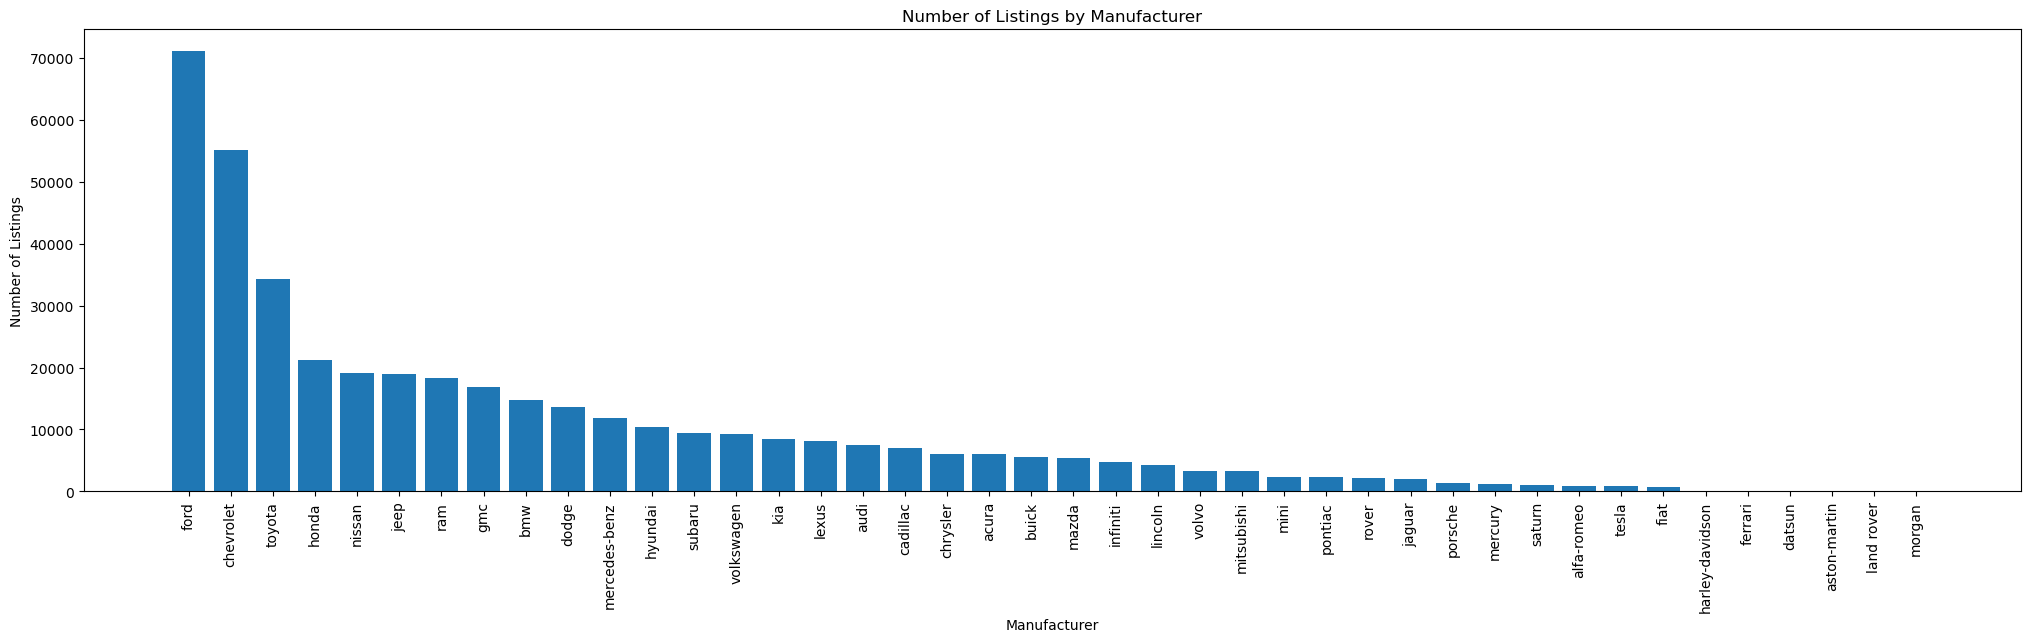

In [7]:
# set up GCS client
client = storage.Client()

# create a bar chart of number of listings by manufacturer
plt.figure(figsize=(25,6))
manufacturer_counts_filtered = manufacturer_counts.filter(F.col('manufacturer').isNotNull() & F.col('num_listings').isNotNull())
manufacturer_counts_updated = manufacturer_counts_filtered.select('manufacturer', 'num_listings').orderBy('num_listings', ascending=False).collect()
manufacturer = [row.manufacturer for row in manufacturer_counts_updated]
num_listings = [row.num_listings for row in manufacturer_counts_updated]
plt.bar(manufacturer, num_listings)
plt.title('Number of Listings by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)
plt.show()
# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#bucket_name = 'egd-bucket'
#folder_name = 'plots'
#blob_name = 'Number_of_Listings_by_Manufacturer.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')

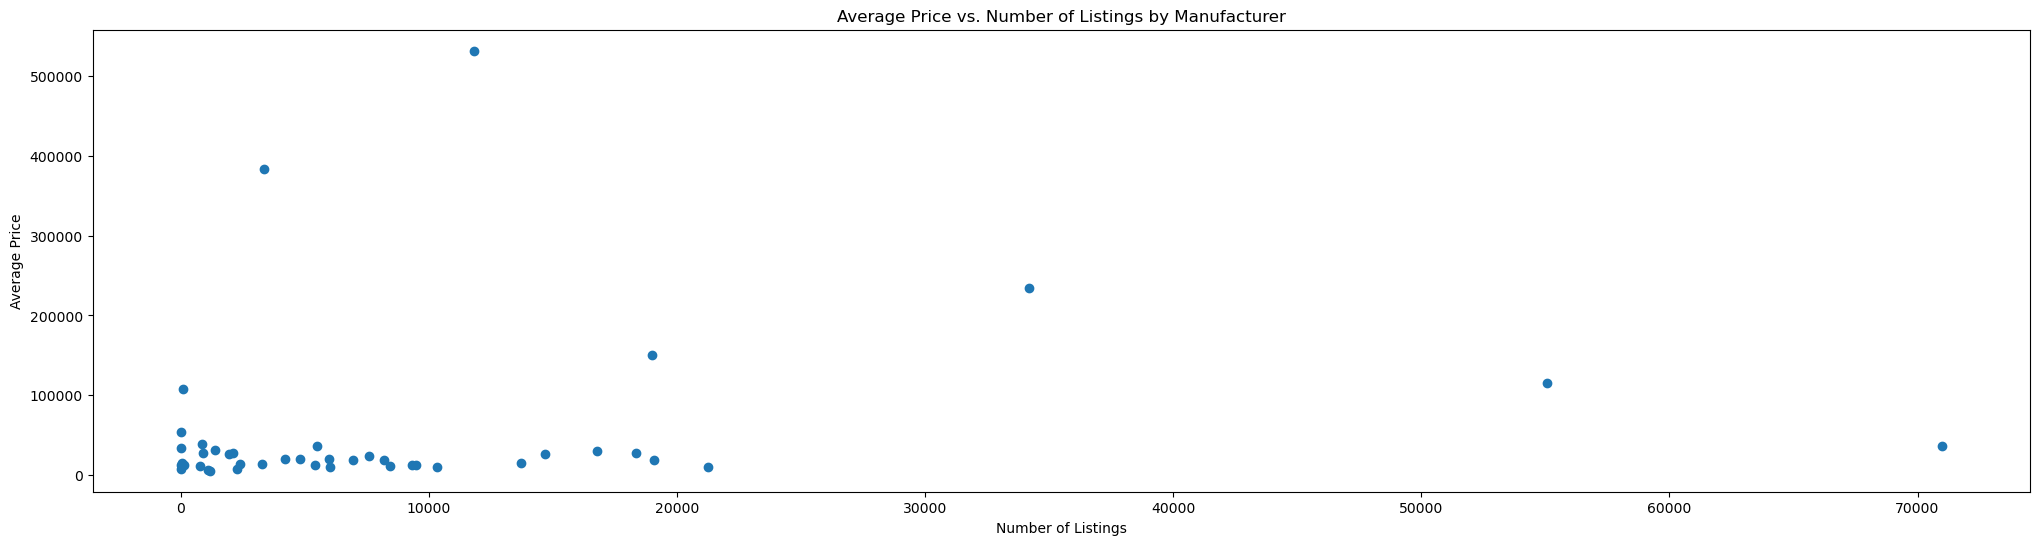

In [8]:
# create a scatterplot of average price vs. number of listings by manufacturer
plt.figure(figsize=(25,6))
df_scatter = manufacturer_counts.select('num_listings', 'avg(price)').collect()
num_listings = [row['num_listings'] for row in df_scatter]
avg_price = [row['avg(price)'] for row in df_scatter]
plt.scatter(num_listings, avg_price)
plt.title('Average Price vs. Number of Listings by Manufacturer')
plt.xlabel('Number of Listings')
plt.ylabel('Average Price')
plt.show()
# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Average_Price_vs_Number_of_Listings_by_Manufacturer.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')

Trying to categorize the number of online dealership, physical dealership, and private party dealer to the best of my ability

In [9]:
online_dealerships = ['carvana', 'vroom', 'shift', 'carMax']
physical_dealerships = ['finance', 'call', 'guaranteed', 'inspection', 'test drive', 'call us today', 'auction', 'visit our', 'automotive']

def categorize_description(description):
    if description is None:
        return 'Private party'
    elif any(keyword in description.lower() for keyword in online_dealerships):
        return 'Online dealership'
    elif any(keyword in description.lower() for keyword in physical_dealerships):
        return 'Physical dealership'
    else:
        return 'Private party'
    
categorize_description_udf = udf(categorize_description, StringType())

# apply the function to each row of the DataFrame
df = df.withColumn('category', categorize_description_udf('description'))

# calculate the percentage of descriptions in each category
category_counts = df.groupby('category').count()
category_counts = category_counts.withColumn('percentage', category_counts['count'] / df.count() * 100).orderBy('percentage', ascending=False)
category_counts.show()

+-------------------+------+------------------+
|           category| count|        percentage|
+-------------------+------+------------------+
|Physical dealership|233240| 54.63830584707646|
|  Online dealership|114452|26.811281859070462|
|      Private party| 79188|18.550412293853075|
+-------------------+------+------------------+



/tmp/ipykernel_4550/2833505496.py:14: UserWarning:                              

FixedFormatter should only be used together with FixedLocator



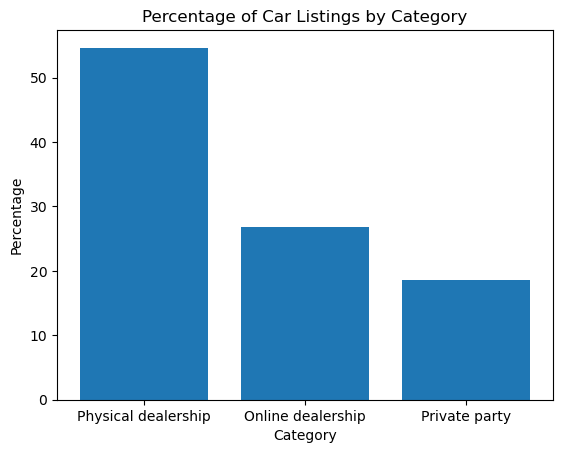

In [10]:
# collect the data
category_counts_list = category_counts.collect()

# extract the data into separate arrays
categories = [row['category'] for row in category_counts_list]
percentages = [row['percentage'] for row in category_counts_list]
# create a figure and axis object
fig, ax = plt.subplots()

# set the x and y labels, title, and rotation of x-tick labels
ax.set_xlabel('Category')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Car Listings by Category')
ax.set_xticklabels(categories, rotation=0)

# create the bar chart
x_pos = np.arange(len(categories))
ax.bar(x_pos, percentages)
ax.set_xticks(x_pos)
plt.show()
# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Percentage_of_Car_Listings_by_Category.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')

What are the oldest cars?

In [11]:
df = df.orderBy('year')
df.show(10)

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+-------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|     category|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+-------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null| 

In [12]:
# create a new DataFrame with the excluded rows removed
df_excluded = df.filter(~(
    lower(col("description")).like("%cash for%") |
    lower(col("description")).like("%provide photos%") |
    lower(col("description")).like("%buying%")
))

# extract the year from the description column
df_excluded = df_excluded.withColumn("year", regexp_extract(col("description"), r"\b(19[0-9][0-9]|20[0-2][0-9])\b", 0))

# convert year column to integer type
df_excluded = df_excluded.withColumn("year", df_excluded["year"].cast("integer"))

# sort the remaining rows by year and show the top 5 oldest cars
oldest_cars = df_excluded.filter(df_excluded.year.isNotNull()).sort("year").select('year', 'price', 'type', 'description').limit(5)
oldest_cars.show()

+----+-----+-----+--------------------+
|year|price| type|         description|
+----+-----+-----+--------------------+
|1900| 1900|truck|Not factory paint...|
|1900|18999|other|Why Buy From Winn...|
|1900|11998| null|If you are a hard...|
|1900| 1900|  SUV|$1900 obo New bat...|
|1900| 1900|sedan|The car runs fine...|
+----+-----+-----+--------------------+



What is the average price and sum of listings per state

In [13]:
# define a UDF to calculate the median
median_udf = expr('percentile_approx(price, 0.5)')

# group by state and calculate count of listings and median price
state_counts = (df.groupBy('state')
                .agg(count('state').alias('num_listings'), median_udf.alias('median_price'))
                .withColumnRenamed('count(state)', 'num_listings')
                .withColumnRenamed('median(price)', 'avg_price'))

# add a new column with row numbers
window = Window.orderBy(asc('state'))
state_counts = (state_counts.withColumn('row_num', row_number().over(window))
                .withColumn('state', upper('state'))  # uppercase state column
                .drop('row_num'))  # drop row_num column

state_counts.show()

+-----+------------+------------+
|state|num_listings|median_price|
+-----+------------+------------+
|   CT|        5188|        9995|
|   WY|         610|       18500|
|   NE|        1036|       13888|
|   IL|       10387|       12995|
|   TX|       22945|       16990|
|   NV|        3194|       16999|
|   OH|       17696|       10950|
|   IN|        5704|       15999|
|   MS|        1016|       12888|
|   NH|        2981|       12575|
|   IA|        8632|       12995|
|   WI|       11398|       13487|
|   NM|        4425|       15990|
|   ME|        2966|        9995|
|   RI|        2320|       11995|
|   NJ|        9742|       10750|
|   CO|       11088|       14999|
|   SC|        6327|       16480|
|   DE|         949|        9795|
|   OK|        6792|       14750|
+-----+------------+------------+
only showing top 20 rows



Create a map of median price of cars by state

In [15]:
# Código para gerar o mapa Plotly
state_counts = (
    df.groupBy('state')
       .agg(F.count('*').alias('Number of cars'),
            F.expr('approx_percentile(price, 0.5)').alias('avg_price'))
)

# Convert state abbreviations to uppercase
state_counts = state_counts.withColumn('state', F.upper(state_counts.state))

# Create a choropleth map using Plotly
fig = px.choropleth(state_counts.toPandas(),
                    locations='state',
                    locationmode='USA-states',
                    color='Number of cars',
                    scope='usa',
                    color_continuous_scale='Blues',
                    range_color=(0, state_counts.select(F.max('Number of cars')).collect()[0][0]),
                    title='Number of cars listed by state'
                   )

# Exibir o gráfico no notebook
fig.show()

#pio.write_html(fig, file='Number_of_cars_listed_by_state.html', auto_open=False)

# Carregar o arquivo HTML no GCS
#with open('Number_of_cars_listed_by_state.html', 'rb') as f:
    #blob_name = 'Number_of_cars_listed_by_state.html'
    #bucket = client.bucket(bucket_name)
    #blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
    #blob.upload_from_file(f, content_type='text/html')

What's the number of listings per state?

In [16]:
# Group by state and aggregate the data
state_counts = (
    df.groupBy('state')
       .agg(F.count('*').alias('num_listings'),
            F.expr('percentile_approx(price, 0.5)').alias('Average price'))
)

# Convert state abbreviations to uppercase
state_counts = state_counts.withColumn('state', F.upper(state_counts.state))

# Create a choropleth map using Plotly
fig = px.choropleth(state_counts.toPandas(),
                    locations='state',
                    locationmode='USA-states',
                    color='Average price',
                    scope='usa',
                    color_continuous_scale='Blues',
                    range_color=(0, state_counts.select(F.max('Average price')).collect()[0][0]),
                    title='Average price of cars listed by state'
                   )

#pio.write_html(fig, file='Average_price_of_cars_listed_by_state.html', auto_open=False)

# Carregar o arquivo HTML no GCS
#with open('Average_price_of_cars_listed_by_state.html', 'rb') as f:
    #blob_name = 'Average_price_of_cars_listed_by_state.html'
    #bucket = client.bucket(bucket_name)
    #blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
    #blob.upload_from_file(f, content_type='text/html')

# Exibir o gráfico no notebook
fig.show()

What percentage of postings for each state is electric cars

In [17]:
# Filter the dataframe for electric cars
electric_cars = df.filter(df['fuel'] == 'electric')

# Group the data by state and count occurrences
state_counts = electric_cars.groupBy('state').agg(count('*').alias('count')).orderBy('count', ascending=False)

# Calculate the total number of electric cars
total_electric_cars = state_counts.agg({'count': 'sum'}).collect()[0][0]

# Calculate the percentage of electric cars in each state
state_percentages = state_counts.withColumn('percentage', state_counts['count'] / total_electric_cars * 100)

# Display the result
state_percentages.show()

+-----+-----+------------------+
|state|count|        percentage|
+-----+-----+------------------+
|   ca|  353|20.789163722025915|
|   fl|  118|6.9493521790341575|
|   tx|   75|  4.41696113074205|
|   ny|   74| 4.358068315665489|
|   or|   73|4.2991755005889285|
|   oh|   59|3.4746760895170787|
|   az|   58| 3.415783274440518|
|   wa|   53| 3.121319199057715|
|   nc|   52|3.0624263839811543|
|   pa|   44|2.5912838633686692|
|   co|   40|2.3557126030624262|
|   wi|   39|2.2968197879858656|
|   nj|   38| 2.237926972909305|
|   mi|   38| 2.237926972909305|
|   il|   37|2.1790341578327443|
|   ga|   36|2.1201413427561837|
|   md|   35| 2.061248527679623|
|   ma|   34|2.0023557126030624|
|   tn|   32| 1.884570082449941|
|   nm|   30|  1.76678445229682|
+-----+-----+------------------+
only showing top 20 rows



What percentage of postings for each state is salvaged cars

In [18]:
# Filter the dataframe for salvage
salvage_cars = df.filter(df.title_status == 'salvage')

# Group the data by state and count occurrences
salvage_counts = salvage_cars.groupBy('state').agg(count('*').alias('count'))

# Calculate the total number of salvage cars
total_salvage_cars = salvage_counts.agg({'count': 'sum'}).collect()[0][0]

# Calculate the percentage of salvage cars in each state and round to 2 decimal places
state_percentages = (salvage_counts.withColumn('percentage', round(salvage_counts['count'] / total_salvage_cars * 100, 2))
                    .select('state', 'percentage'))

# Sort the data by percentage in descending order
state_percentages = state_percentages.orderBy('percentage', ascending=False)

# Display the result
state_percentages.show()

+-----+----------+
|state|percentage|
+-----+----------+
|   ca|      27.4|
|   nc|      7.16|
|   tx|      6.41|
|   pa|      5.84|
|   sc|      5.04|
|   ia|      4.21|
|   nm|      3.88|
|   mn|      3.85|
|   or|       3.1|
|   oh|      2.53|
|   mi|      2.38|
|   az|      1.99|
|   ny|      1.94|
|   wi|      1.89|
|   co|      1.63|
|   id|      1.58|
|   fl|      1.45|
|   tn|       1.4|
|   sd|       1.4|
|   nj|      1.32|
+-----+----------+
only showing top 20 rows



# Data Visualization & Cleaning

In [19]:
# Determine and remove the columns to drop based on the above graph
cols_to_drop = ['id','url', 'region', 'region_url', 'VIN', 'image_url', 'description', \
    'county', 'size', 'paint_color', 'drive', 'cylinders', 'state', 'lat','long']
vehicles_df = df.select([col(c) for c in df.columns if c not in cols_to_drop])

# Remove null values and duplicated rows
vehicles_df = vehicles_df.dropna().dropDuplicates()

# Get info of the new data frame
vehicles_df.printSchema()

root
 |-- price: long (nullable = true)
 |-- year: double (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- type: string (nullable = true)
 |-- posting_date: string (nullable = true)
 |-- category: string (nullable = true)



In [20]:
# Preview the new dataframe
list(vehicles_df)

[Column<'price'>,
 Column<'year'>,
 Column<'manufacturer'>,
 Column<'model'>,
 Column<'condition'>,
 Column<'fuel'>,
 Column<'odometer'>,
 Column<'title_status'>,
 Column<'transmission'>,
 Column<'type'>,
 Column<'posting_date'>,
 Column<'category'>]

Upon reviewing the previews and descriptions of the continuous variables, it becomes clear that some initial cleaning is necessary. This will be continued accordingly.

In [21]:
# Drop NaNs and duplicates
vehicles_df = vehicles_df.dropna().dropDuplicates()

# Add index column using monotonically_increasing_id() function
vehicles_df = vehicles_df.withColumn("index", monotonically_increasing_id())

# Change data type of year to string
vehicles_df = vehicles_df.withColumn("year", col("year").cast("string"))

# Reorder columns with index first
vehicles_df = vehicles_df.select("index", *vehicles_df.columns[:-1])

Visualizing the data reveals patterns that are not obvious to the human eye when reviewing raw data.

Correlation matrices, histograms, category, scatter & box plots have helped identify relationships.

Cleaned data based on visualizations:

 - Removed NaNs & duplicates
 - Price b/w 2k and 50k
 - Odometer b/w 100 and 200k, etc..

In the section below, features that would help with better prediction are identified.

In [22]:
# Describing the dataset to get a basic idea of the non-categorical features
vehicles_df.select([col(c).cast("float") for c in vehicles_df.columns if c not in ['manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type']]).describe().show()

+-------+-------------------+------------------+------------------+-----------------+------------+--------+
|summary|              index|             price|              year|         odometer|posting_date|category|
+-------+-------------------+------------------+------------------+-----------------+------------+--------+
|  count|             202122|            202122|            202122|           202122|           0|       0|
|   mean|4.301732630314152E9|44802.259946962724|2011.5864428414523|91518.98221866002|        null|    null|
| stddev|  4.2949727507456E9|  8689932.80119766| 8.781934191239174|193730.1244247275|        null|    null|
|    min|                0.0|               0.0|            1900.0|              0.0|        null|    null|
|    max|         8.590036E9|      3.73692877E9|            2022.0|            1.0E7|        null|    null|
+-------+-------------------+------------------+------------------+-----------------+------------+--------+



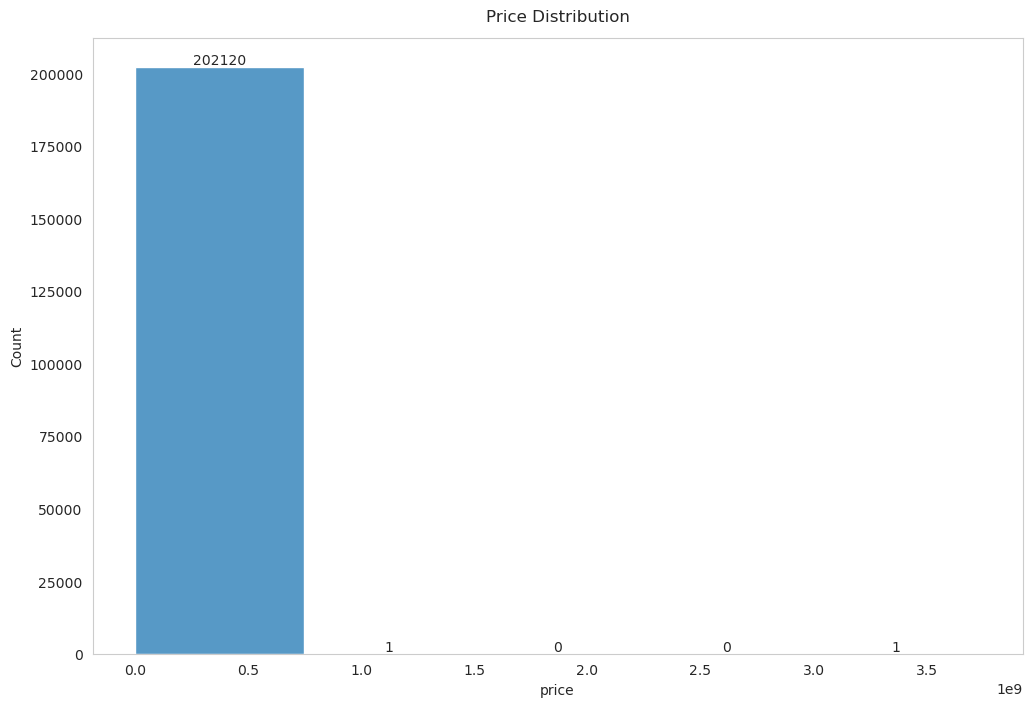

In [23]:
# Set seaborn style
sns.set_style('whitegrid')

# Looking at the target column "price" first
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price Distribution', pad=12)
ax.grid(False)
# Convert spark dataframe to pandas dataframe
price_df = vehicles_df.select(col("price")).toPandas()

# Plot histogram using pandas dataframe
sns.histplot(data=price_df, x="price", stat='count', bins=5)
show_values_on_bars(ax)

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Price_Distribution_Count.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

It appears that the price ranges between 0 and an unrealistic $3.7B

To keep things simple and realistic, making a subset of prices between 2k and 50k

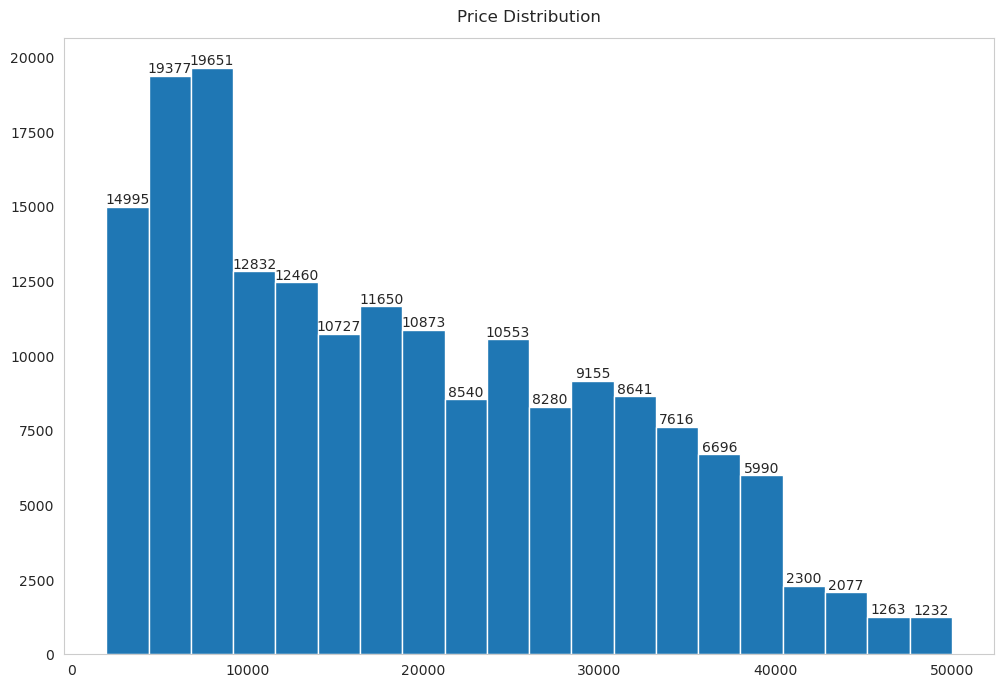

In [24]:
# Create a new Spark DataFrame with the filtered data
vehicles_prc = vehicles_df.filter((vehicles_df.price >= 2000) & (vehicles_df.price <= 50000))

# Extract the data from the DataFrame as a list
prices = vehicles_prc.select('price').rdd.flatMap(lambda x: x).collect()

# Plot the histogram
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price Distribution', pad=12)
ax.hist(prices, bins=20)
ax.grid(False)
show_values_on_bars(ax)
plt.show()
# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Price_Distribution_2000&50000.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')

Skewness for odometer: 48.58


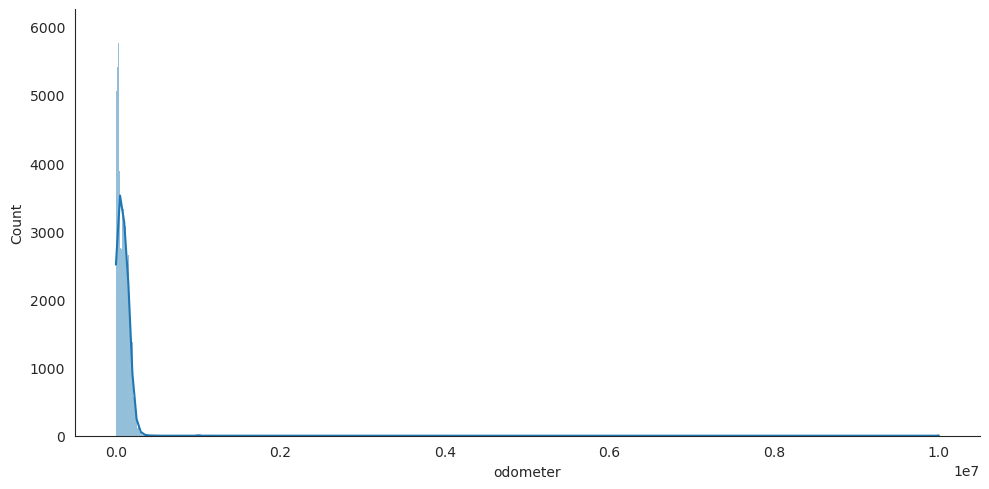

In [25]:
# Calculate skewness of odometer column
odometer_skew = vehicles_prc.select(skewness("odometer")).collect()[0][0]
print(f"Skewness for odometer: {odometer_skew:.2f}")

# Create a Pandas DataFrame from the Spark DataFrame
vehicles_prc_pd = vehicles_prc.select("odometer").toPandas()

# Set style without grid
sns.set_style("white")

# Plot histogram with Seaborn
sns.displot(data=vehicles_prc_pd, x="odometer", aspect=2, height=5, kde=True)
plt.show()
# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Skewness_Odometer.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')

It's evident that the distribution is highly skewed and there's some bad data with max odometer readings of 10mil miles etc.

Let's work on cleaning up some of that data.

Doing some research, We found that Americans drive an average of 14,300 miles per year, according to the Federal Highway Administration.

Let's look at the entries for odometer = 0 and odometer > 200k.

In [26]:
# Describe vehicles with 0 odometer
vehicles_prc.filter(col("odometer") == 0).describe().show()

# Describe vehicles with odometer over 200,000
vehicles_prc.filter(col("odometer") > 200000).describe().show()

+-------+-------------------+------------------+------------------+------------+------------------+---------+------+--------+------------+------------+-----+--------------------+-----------------+
|summary|              index|             price|              year|manufacturer|             model|condition|  fuel|odometer|title_status|transmission| type|        posting_date|         category|
+-------+-------------------+------------------+------------------+------------+------------------+---------+------+--------+------------+------------+-----+--------------------+-----------------+
|  count|                277|               277|               277|         277|               277|      277|   277|     277|         277|         277|  277|                 277|              277|
|   mean|9.458262962310469E9|13709.768953068593|2003.5776173285199|        null|1594.1176470588234|     null|  null|     0.0|        null|        null| null|                null|             null|
| stddev|7.0738

+-------+-------------------+------------------+------------------+------------+------------------+---------+------+------------------+------------+------------+-----+--------------------+-----------------+
|summary|              index|             price|              year|manufacturer|             model|condition|  fuel|          odometer|title_status|transmission| type|        posting_date|         category|
+-------+-------------------+------------------+------------------+------------+------------------+---------+------+------------------+------------+------------+-----+--------------------+-----------------+
|  count|               9371|              9371|              9371|        9371|              9371|     9371|  9371|              9371|        9371|        9371| 9371|                9371|             9371|
|   mean| 8.78979756146313E9| 7702.859353324085|2004.3890726710063|        null|2229.6985221674877|     null|  null|296067.16145555436|        null|        null| null|     

Based on the stats above, We can make a fair assumption that odometer readings be between 100 (CPO) to 200k (20 yo) will be a good dataset to continue with.

+-------+-----------------+
|summary|         odometer|
+-------+-----------------+
|  count|           174612|
|   mean|79143.34234187799|
| stddev|54218.50054397939|
|    min|            101.0|
|    max|         200000.0|
+-------+-----------------+



Skewness for odometer:	48.58


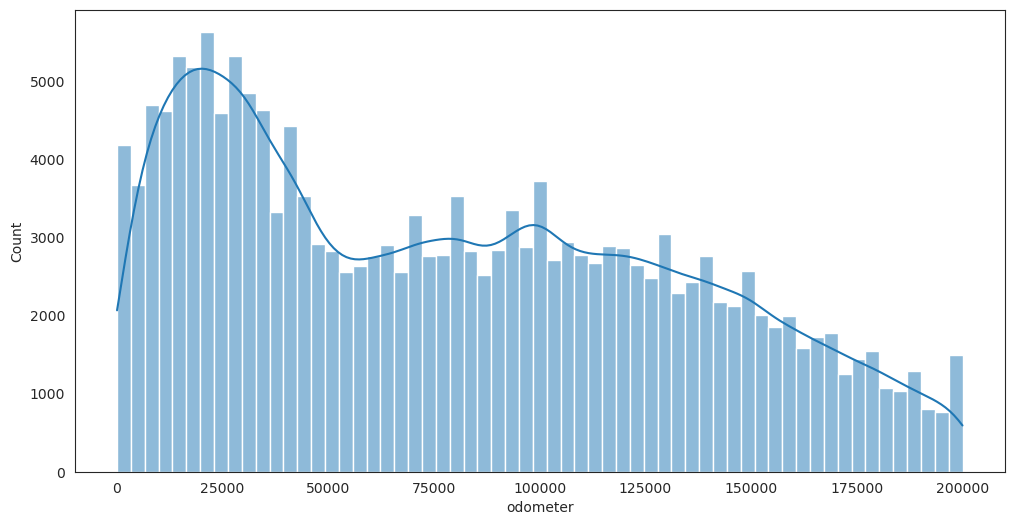

In [27]:
# Filtering the dataset and verifying again
vehicles_odo = vehicles_prc.filter((col("odometer") > 100) & (col("odometer") <= 200000))

# Displaying statistics
vehicles_odo.select("odometer").describe().show()

# Displaying skewness
skewness = vehicles_prc.select(F.skewness("odometer")).collect()[0][0]
print(f"Skewness for odometer:\t{skewness:.2f}")

# Set the figure size
plt.figure(figsize=(12, 6))

# Set style without grid
sns.set_style("white")

# Displaying distribution plot
sns.histplot(data=vehicles_odo.toPandas(), x="odometer", kde=True)

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Skewness_Odometer_100&200000.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

With that, the skewness comes down from 41.63 to just 0.37 - although still positively skewed, it's worth exploring what log and square root can do..

Skewness for Log of Odometer Readings::	: -1.62


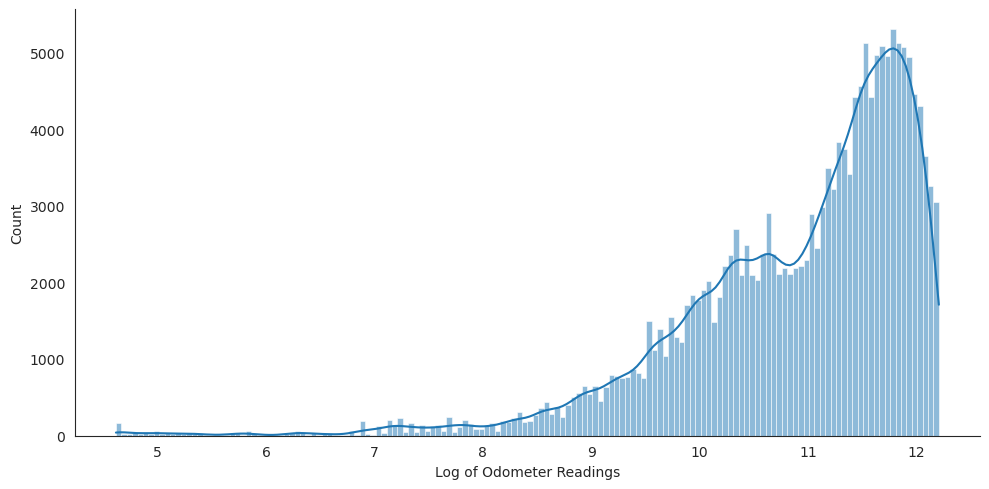

In [28]:
# Log
odo_log = vehicles_odo.select(log('odometer').alias('odometer_log'))
odo_log_skew = odo_log.select(F.skewness('odometer_log').alias('skewness')).collect()[0]['skewness']
print(f"Skewness for Log of Odometer Readings::\t: {odo_log_skew:.2f}")

# Plot
odo_log_pd = odo_log.toPandas()
sns.set_style("white")
sns.displot(data=odo_log_pd, x='odometer_log', aspect=2, height=5, kde=True, legend=True)
plt.xlabel('Log of Odometer Readings')

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Skewness_Log_of_Odometer.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

Skewness for Square Root of Odometer Readings::	: -0.20


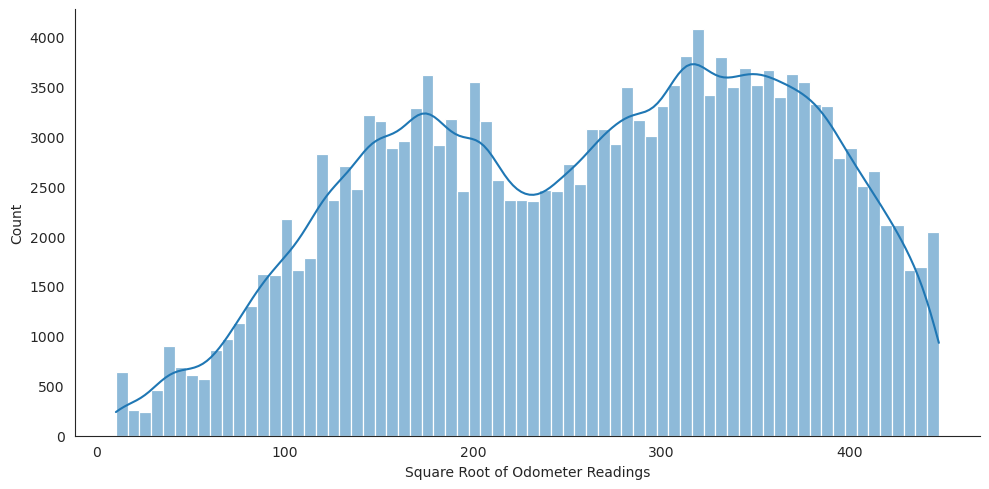

In [29]:
# Square Root
odo_sqrt = vehicles_odo.select(sqrt('odometer').alias('odometer_sqrt'))
odo_sqrt_skew = odo_sqrt.select(F.skewness('odometer_sqrt').alias('skewness')).collect()[0]['skewness']
print(f"Skewness for Square Root of Odometer Readings::\t: {odo_sqrt_skew:.2f}")

# Plot
odo_sqrt_pd = odo_sqrt.toPandas()
sns.set_style("white")
sns.displot(data=odo_sqrt_pd, x='odometer_sqrt', aspect=2, height=5, kde=True, legend=True)
plt.xlabel('Square Root of Odometer Readings')

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Skewness_Square_of_Odometer.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

That didn't help.. so proceeding without log or sqrt, next step is to see how the age of cars and the odometer readings are related to the price of cars

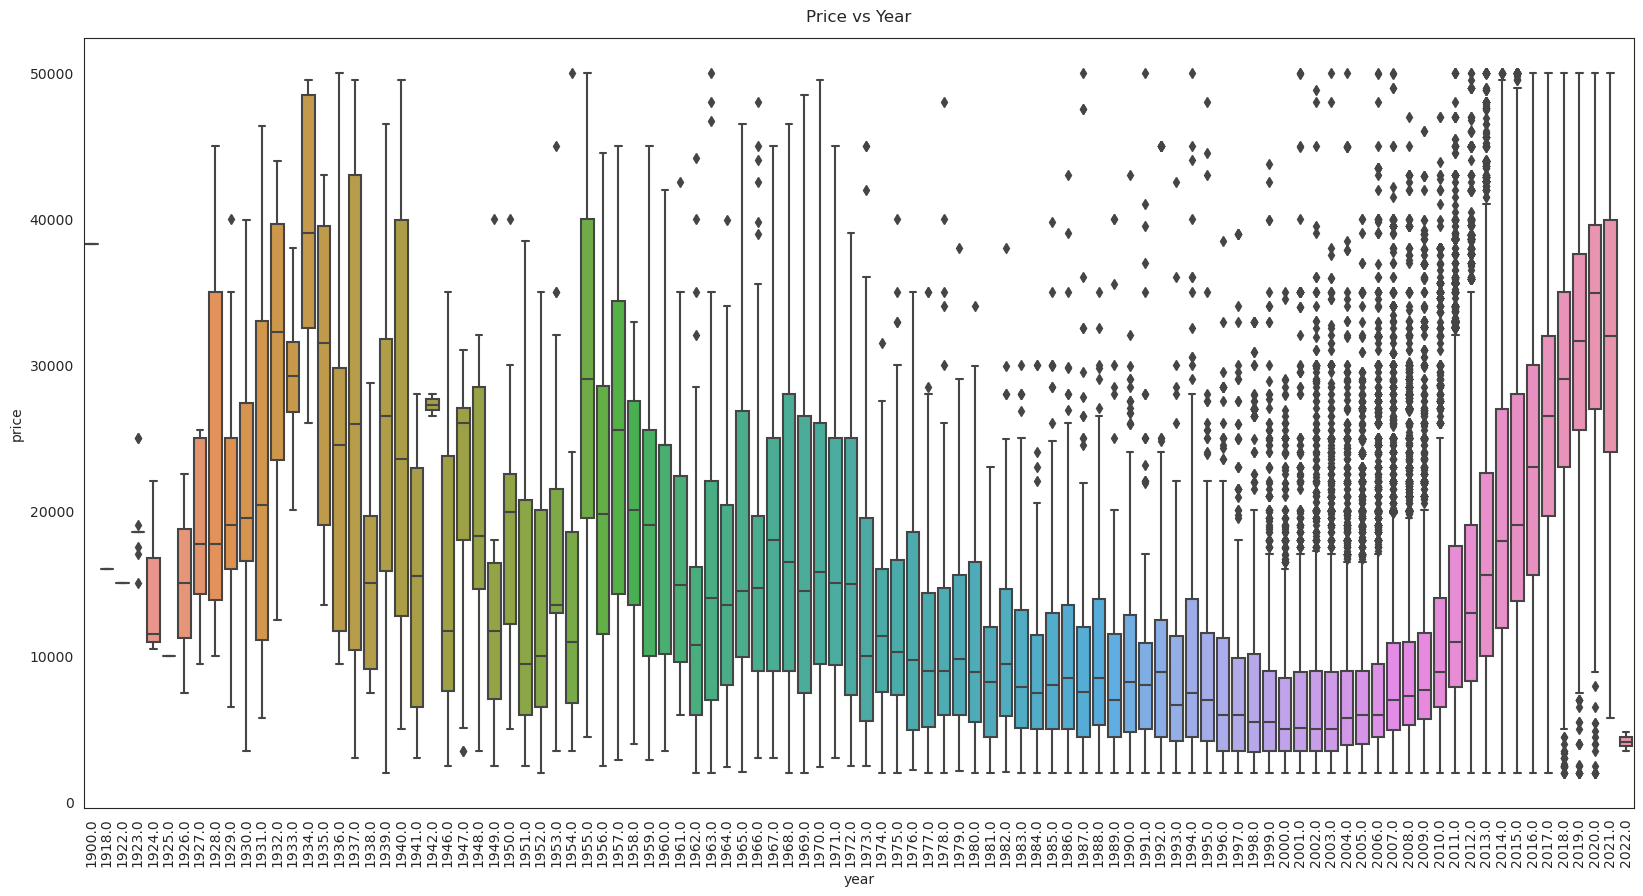

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Price vs Year', pad=12)
sns_df = vehicles_odo.select('year', 'price').toPandas()

# Ordenando os anos
sns_df = sns_df.sort_values(by='year')

sns.boxplot(x='year', y='price', data=sns_df, ax=ax)
plt.xticks(rotation=90)
plt.show()
# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Price_vs_Year.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')

It appears that there is some inconsistency in the first 2/3rds of the dataset.

Price seems to consistently rise 2000 onwards until about 2021; and there seems to be some bad data for 2022 as well.

Filtering the dataset between 2000 and 2020 for further analysis.

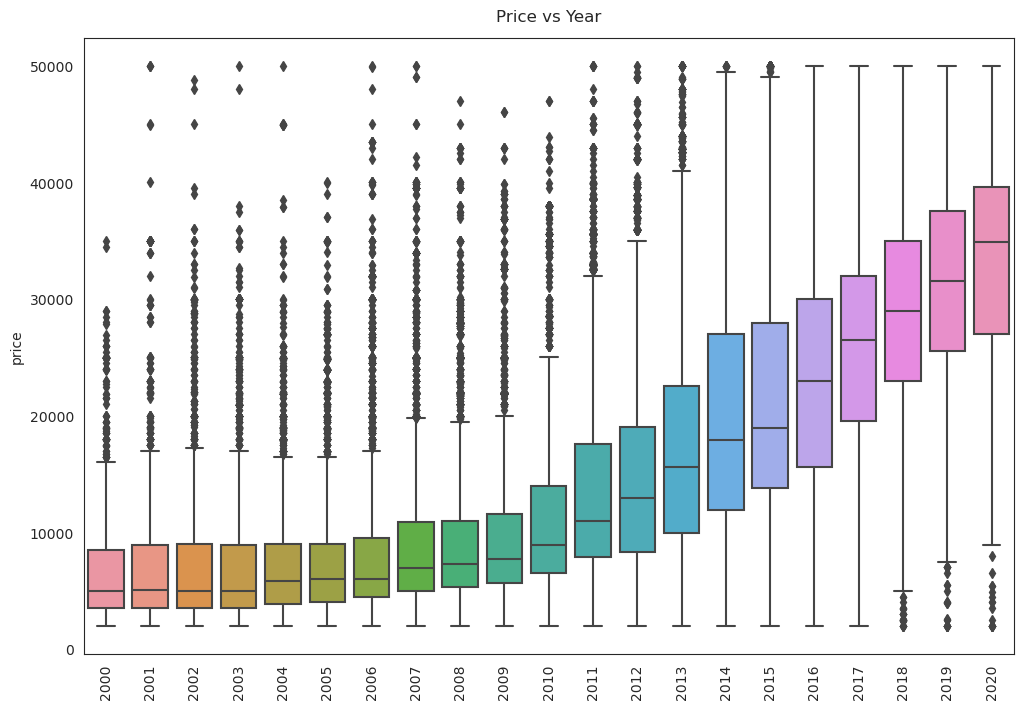

In [ ]:
year_list = list(range(2000, 2021))
vehicles_year = vehicles_odo.filter(col('year').cast(IntegerType()).isin(year_list))

# Collect the year column as a list and pass it to the x parameter of boxplot
year_collected = [row[0] for row in vehicles_year.select(col('year').cast(IntegerType())).collect()]
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price vs Year', pad=12)
ax.grid(False)
sns.boxplot(x=year_collected,
            y='price',
            data=vehicles_year.toPandas(),
            ax=ax)
plt.xticks(rotation=90);

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Price_vs_Year_2000_2021.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

In [32]:
vehicles_year.show()

+-----+-----+------+------------+--------------------+---------+------+--------+------------+------------+---------+--------------------+-------------------+
|index|price|  year|manufacturer|               model|condition|  fuel|odometer|title_status|transmission|     type|        posting_date|           category|
+-----+-----+------+------------+--------------------+---------+------+--------+------------+------------+---------+--------------------+-------------------+
|    0|39590|2020.0|   chevrolet| silverado 1500 crew|     good|   gas| 19160.0|       clean|       other|   pickup|2021-05-04T11:51:...|  Online dealership|
|    2|12990|2013.0|       volvo|     s60 t5 sedan 4d|     good|   gas| 86614.0|       clean|       other|    sedan|2021-04-13T12:21:...|  Online dealership|
|    3|25990|2016.0|      toyota|tacoma access cab...|     good| other| 79393.0|       clean|       other|   pickup|2021-04-09T09:21:...|  Online dealership|
|    4|36590|2020.0|       volvo|s60 t6 r-design s..

With this used 20 year set, next, trying to find how the three features come together and depict real-worl characteristics. Checking how price varies with mean odometer ratings over the age of the car posted.

In [33]:
# Convert posting_date to a date type
vehicles_year = vehicles_year.withColumn('posting_date', to_date('posting_date'))

# Add a new column for age of cars
vehicles_year = vehicles_year.withColumn('age', year('posting_date') - vehicles_year['year'])

# Preview the changes
vehicles_year.show()

+-----+-----+------+------------+--------------------+---------+------+--------+------------+------------+---------+------------+-------------------+----+
|index|price|  year|manufacturer|               model|condition|  fuel|odometer|title_status|transmission|     type|posting_date|           category| age|
+-----+-----+------+------------+--------------------+---------+------+--------+------------+------------+---------+------------+-------------------+----+
|    0|39590|2020.0|   chevrolet| silverado 1500 crew|     good|   gas| 19160.0|       clean|       other|   pickup|  2021-05-04|  Online dealership| 1.0|
|    2|12990|2013.0|       volvo|     s60 t5 sedan 4d|     good|   gas| 86614.0|       clean|       other|    sedan|  2021-04-13|  Online dealership| 8.0|
|    3|25990|2016.0|      toyota|tacoma access cab...|     good| other| 79393.0|       clean|       other|   pickup|  2021-04-09|  Online dealership| 5.0|
|    4|36590|2020.0|       volvo|s60 t6 r-design s...|     good|   gas

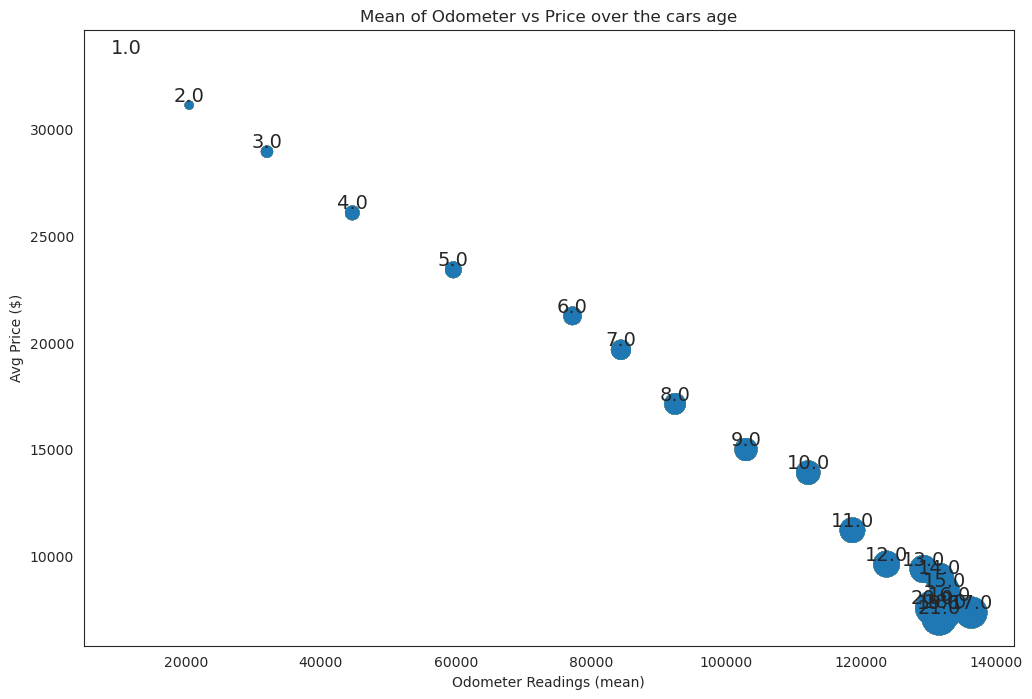

In [34]:
# Get mean of odometer readings by age
grp_df = vehicles_year.groupBy('age').agg(avg('price').alias('avg_price'), avg('odometer').alias('avg_odometer')).orderBy('age')

# Visualize how odometer average readings vary with price over age of cars
# Set axes and points 
x = [row.avg_odometer for row in grp_df.collect()]
y = [row.avg_price for row in grp_df.collect()]
points = [row.age for row in grp_df.collect()]
s = [30*n for n in range(len(y))]

f, ax = plt.subplots(figsize=(12, 8))
# Plot for each year
plt.title(f"Mean of Odometer vs Price over the cars age")
plt.xlabel("Odometer Readings (mean)")
plt.ylabel("Avg Price ($)")
ax.grid(False)

# Add labels for weeks
for i, week in enumerate(points):
    plt.annotate(week, (x[i], y[i]), size=14, va="bottom", ha="center")
    plt.scatter(x, y, s=s)

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Mean_of_Odometer_vs_Price_over_Age.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

It's evident that cars that have been driven less are more expensive than older cars which have been driven more. There seem to be a good chunk of cars under 10k that have been driven 120k and over and are 12 years and older - this is an interesting insight.

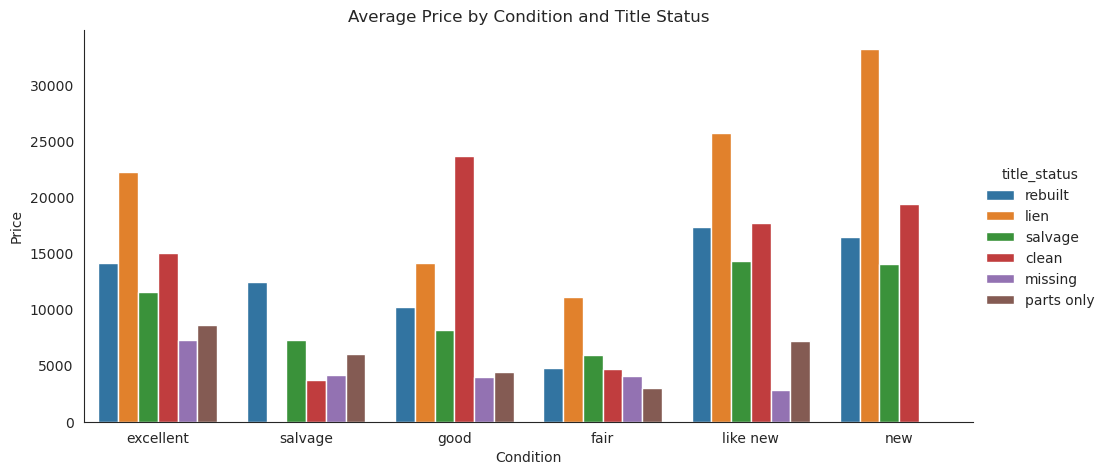

In [35]:
# Group by condition and title_status columns and aggregate the mean of price
grouped_df = vehicles_year.groupBy('condition', 'title_status').agg({'price': 'mean'})

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()

sns.catplot(x='condition', y='avg(price)', hue='title_status', data=pandas_df,
            kind='bar', aspect=2, height=5)

plt.subplots_adjust(top=0.9) # Aumenta a margem superior para liberar mais espaço para o título
# Set plot labels and title
plt.xlabel('Condition')
plt.ylabel('Price')
plt.title('Average Price by Condition and Title Status')

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Average_Price_by_Condition_and_Title_Status.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

Since we want to look at only used cars, ignoring new cars for the moment.

It also looks like there are only parts being sold - which might affect the price.

Removing both these attributes..

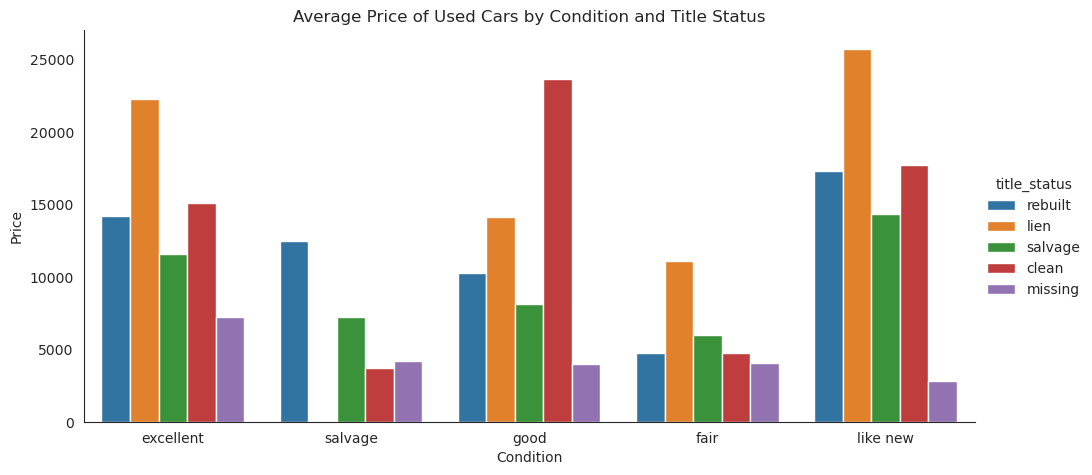

In [36]:
# Filter the Spark DataFrame to include only used cars
vehicles_used = vehicles_year.filter(col('condition') != 'new')

# Filter the Spark DataFrame to exclude cars with title_status 'parts only'
vehicles_used = vehicles_used.filter(col('title_status') != 'parts only')

# Group by condition and title_status columns and aggregate the mean of price
grouped_df = vehicles_used.groupBy('condition', 'title_status').agg({'price': 'mean'})

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()

# Create plot
sns.catplot(x='condition', y='avg(price)', hue='title_status', data=pandas_df,
            kind='bar', aspect=2, height=5)
plt.subplots_adjust(top=0.9) # Aumenta a margem superior para liberar mais espaço para o título

# Set plot labels and title
plt.xlabel('Condition')
plt.ylabel('Price')
plt.title('Average Price of Used Cars by Condition and Title Status')

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Average_Price_by_Condition_and_Title_Status_without_new&parts_only.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

On to the next, understanding how price of cars is affected by the fuel and trasmission features...

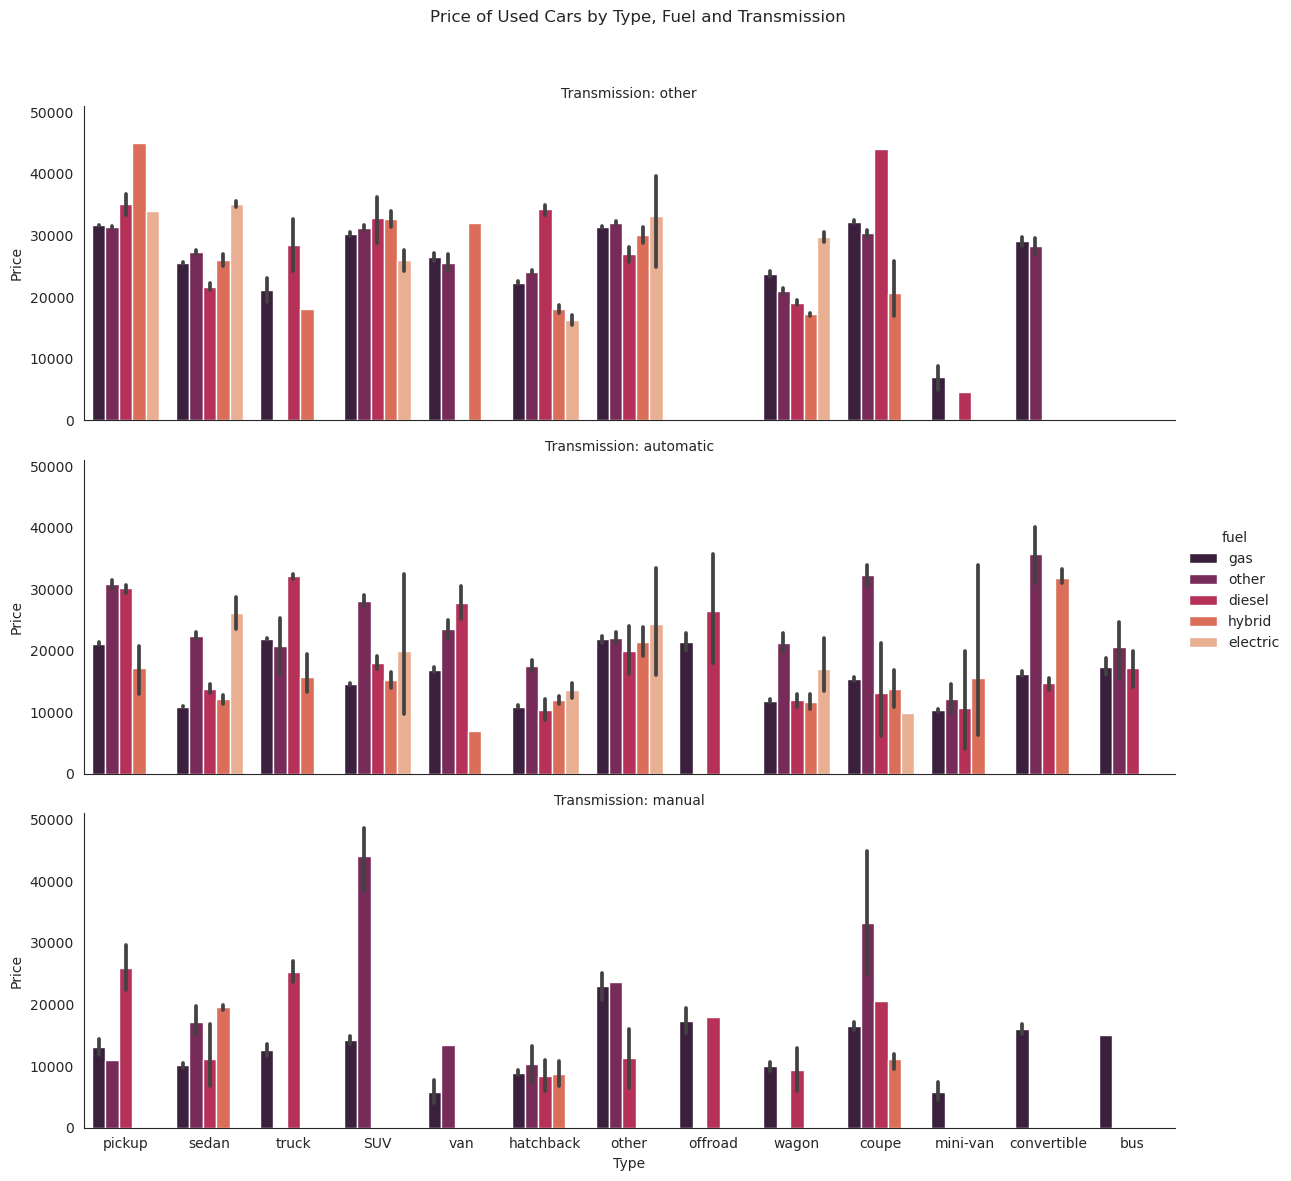

In [37]:
# Filter the Spark DataFrame to include only used cars
vehicles_used = vehicles_year.filter(col('condition') != 'new')

# Filter the Spark DataFrame to exclude cars with title_status 'parts only'
vehicles_used = vehicles_used.filter(col('title_status') != 'parts only')

# Create plot
g = sns.catplot(x='type', y='price', hue='fuel', col='transmission', data=vehicles_used.toPandas(),
                kind='bar', aspect=3, height=4, palette='rocket', col_wrap=1)

# Set plot labels and title
g.set_axis_labels('Type', 'Price')
g.set_titles('Transmission: {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Price of Used Cars by Type, Fuel and Transmission')

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Price_of_Used_Cars_by_Type_Fuel_and_Transmission.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

It's noted that "other" values for type of fuels and trasmissions contribute to a considerable volume of data.

These, which are not a lot of value might affect the overall accuracy - hence removing them..

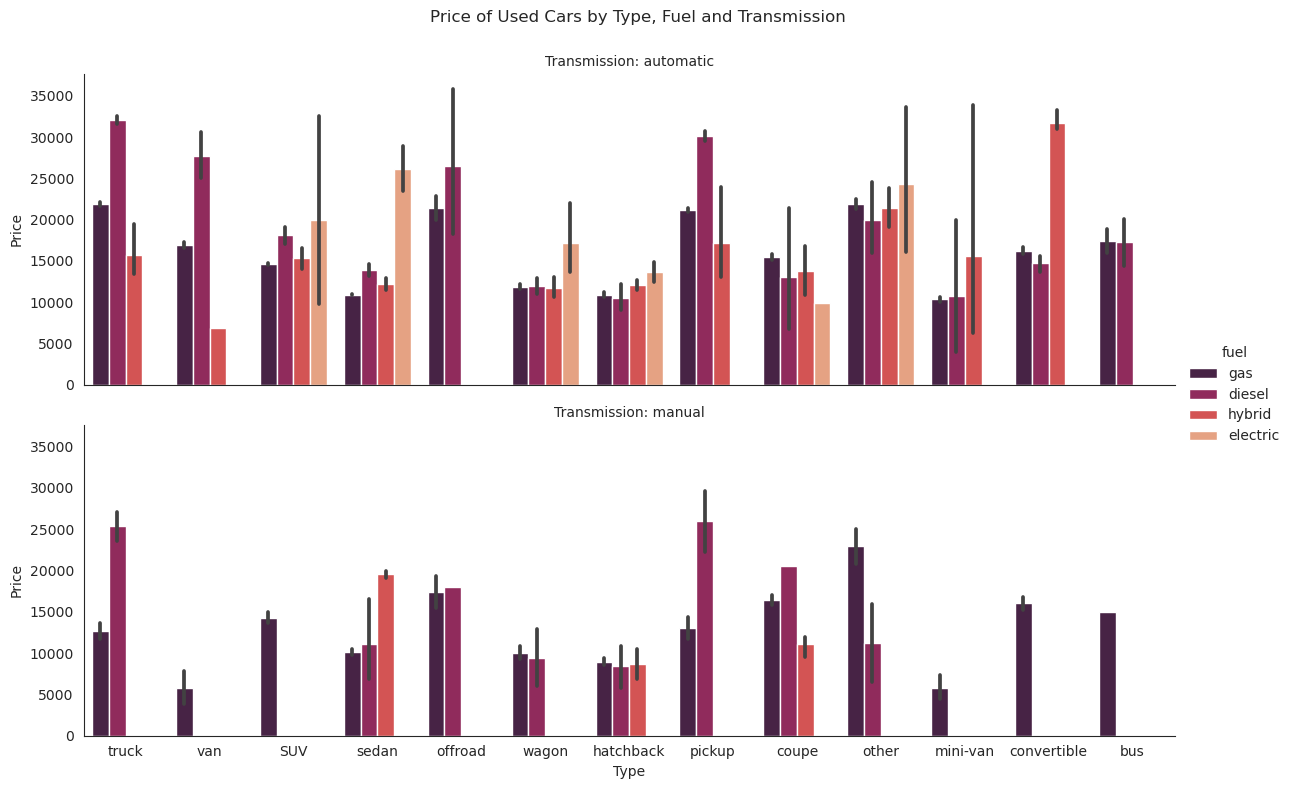

In [38]:
# Filter the Spark DataFrame to include only used cars
vehicles_used = vehicles_year.filter(col('condition') != 'new')

# Filter the Spark DataFrame to exclude cars with title_status 'parts only'
vehicles_used = vehicles_used.filter(col('title_status') != 'parts only')

# Filter the Spark DataFrame to exclude fuel types 'other'
vehicles_used = vehicles_used.filter(col('fuel') != 'other')

# Filter the Spark DataFrame to exclude transmission types 'other'
vehicles_used = vehicles_used.filter(col('transmission') != 'other')

# Create plot
g = sns.catplot(x='type', y='price', hue='fuel', col='transmission', data=vehicles_used.toPandas(),
                kind='bar', aspect=3, height=4, palette='rocket', col_wrap=1)

# Set plot labels and title
g.set_axis_labels('Type', 'Price')
g.set_titles('Transmission: {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Price of Used Cars by Type, Fuel and Transmission')

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Price_of_Used_Cars_by_Type_Fuel_and_Transmission_without_new&parts_only_other.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

Next, we see how price is related to different kinds of manufacturers and the models they produce.

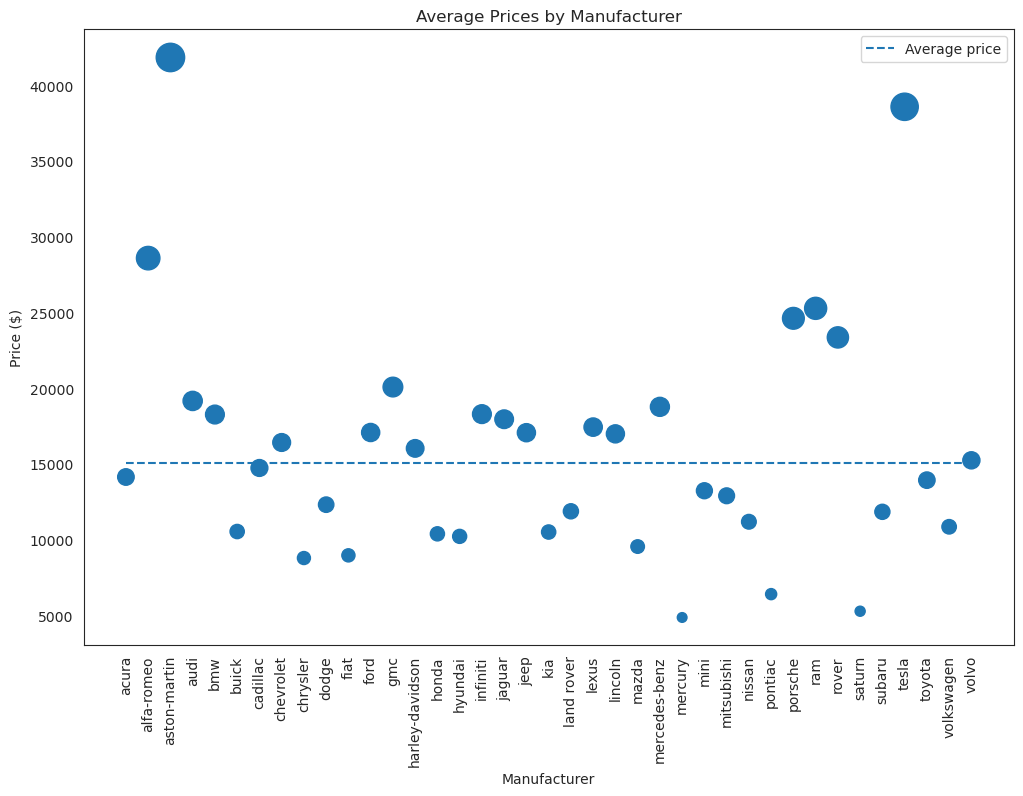

In [39]:
# Visualize the relationship of average price by manufacturer
grp_man_df = vehicles_used.groupBy('manufacturer').agg(avg('price').alias('avg_price')).orderBy('manufacturer')

x = [row.manufacturer for row in grp_man_df.collect()]
y = [row.avg_price for row in grp_man_df.collect()]
y_mean = [vehicles_used.select(avg('price')).collect()[0][0]]*len(grp_man_df.collect())

f, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('white') # Define a cor de fundo do gráfico como branco
ax.scatter(x, y, s=[p/100 for p in y])
ax.plot(x, y_mean, label='Average price', linestyle='--')
ax.grid(False)

plt.title(f"Average Prices by Manufacturer")
plt.ylabel("Price ($)")
plt.xlabel("Manufacturer")
plt.xticks(rotation=90)
plt.legend()

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Average_Prices_by_Manufacturer.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

It's obviously evident that luxury brands have a higer price, but except a couple outliers, the median price lies near most points

Finally, we explore the "model" feature which I imagine has the highest cardinality amongst all the features we've seen so far..

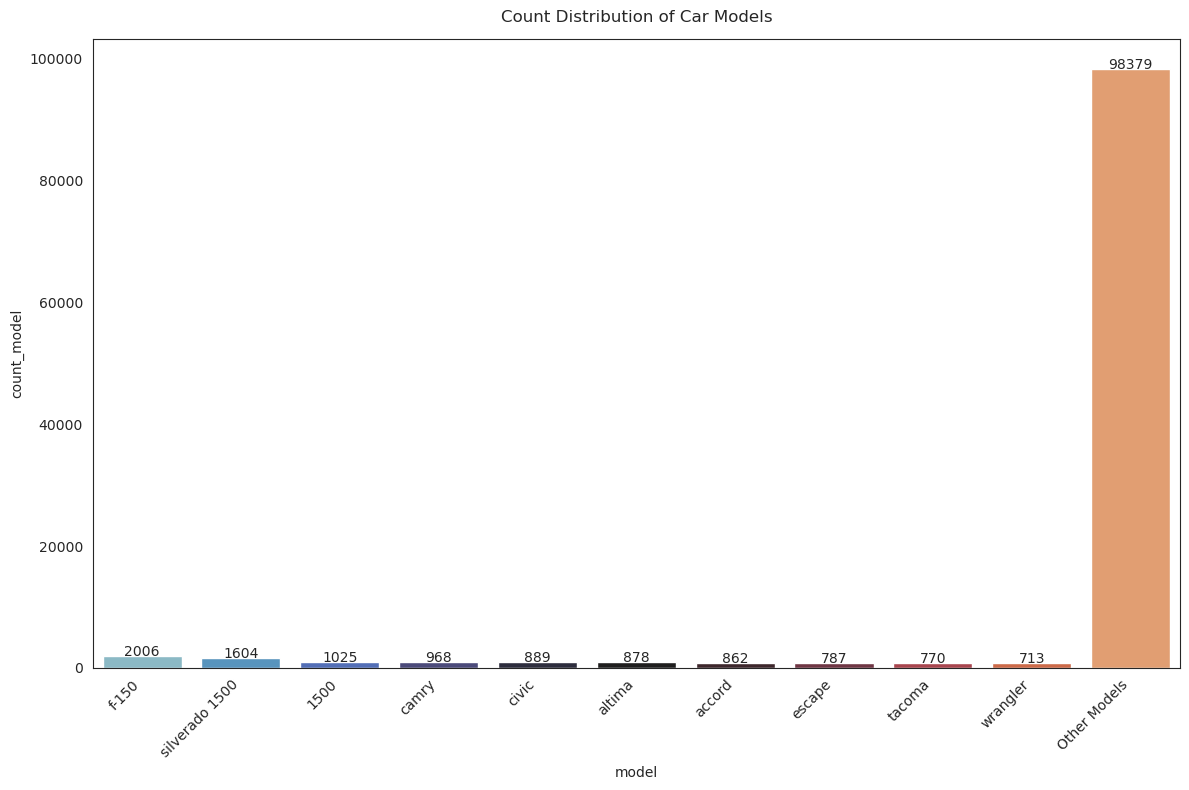

In [40]:
# Add a field for row numbers
vehicles_used = vehicles_used.withColumn("row_num", row_number().over(Window.orderBy(col("model"))))

# Get counts of models
model_df = vehicles_used.groupBy("model").count().withColumnRenamed("count", "count_model")

# Get only 10 frequent models and how much the other account to
lar10_df = model_df.orderBy(col("count_model").desc()).limit(10).toPandas()
other_val_sum = model_df.selectExpr("sum(count_model) as other_count").collect()[0].other_count - lar10_df["count_model"].sum()
lar10_df.loc[10] = ['Other Models', other_val_sum]

# Plot what the counts of models look like
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Count Distribution of Car Models', pad=12)
sns.barplot(x="model", y="count_model",  palette="icefire",  data=lar10_df)
for i, row in lar10_df.iterrows():
    ax.text(i, row["count_model"] + 2, row["count_model"], ha="center")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Count_Distribution_of_Car_Models.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')
plt.show()

## DATA CLEANING SIMPLIFIED 

In [ ]:
# CLEANING SIMPLIFIED 

# Determine and remove the columns to drop based on the above graph
cols_to_drop = ['id','url', 'region', 'region_url', 'VIN', 'image_url', 'description', \
    'county', 'size', 'paint_color', 'drive', 'cylinders', 'state', 'lat','long']
vehicles_df = df.select([col(c) for c in df.columns if c not in cols_to_drop])

# Remove null values and duplicated rows
vehicles_df = vehicles_df.dropna().dropDuplicates()

# Drop NaNs and duplicates
vehicles_df = vehicles_df.dropna().dropDuplicates()

# Add index column using monotonically_increasing_id() function
vehicles_df = vehicles_df.withColumn("index", monotonically_increasing_id())

# Change data type of year to string
vehicles_df = vehicles_df.withColumn("year", col("year").cast("string"))

# Reorder columns with index first
vehicles_df = vehicles_df.select("index", *vehicles_df.columns[:-1])

# Describing the dataset to get a basic idea of the non-categorical features
vehicles_df.select([col(c).cast("float") for c in vehicles_df.columns if c not in ['manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type']])

# Create a new Spark DataFrame with the filtered data
vehicles_prc = vehicles_df.filter((vehicles_df.price >= 2000) & (vehicles_df.price <= 50000))

vehicles_odo = vehicles_prc.filter((col("odometer") > 100) & (col("odometer") <= 200000))

year_list = list(range(2000, 2021))
vehicles_year = vehicles_odo.filter(col('year').cast(IntegerType()).isin(year_list))

# Convert posting_date to a date type
vehicles_year = vehicles_year.withColumn('posting_date', to_date('posting_date'))

# Add a new column for age of cars
vehicles_year = vehicles_year.withColumn('age', year('posting_date') - vehicles_year['year'])

# Group by condition and title_status columns and aggregate the mean of price
grouped_df = vehicles_year.groupBy('condition', 'title_status').agg({'price': 'mean'})

# Filter the Spark DataFrame to include only used cars
vehicles_used = vehicles_year.filter(col('condition') != 'new')

# Filter the Spark DataFrame to exclude cars with title_status 'parts only'
vehicles_used = vehicles_used.filter(col('title_status') != 'parts only')

# Group by condition and title_status columns and aggregate the mean of price
grouped_df = vehicles_used.groupBy('condition', 'title_status').agg({'price': 'mean'})

# Filter the Spark DataFrame to include only used cars
vehicles_used = vehicles_year.filter(col('condition') != 'new')

# Filter the Spark DataFrame to exclude cars with title_status 'parts only'
vehicles_used = vehicles_used.filter(col('title_status') != 'parts only')

# Filter the Spark DataFrame to include only used cars
vehicles_used = vehicles_year.filter(col('condition') != 'new')

# Filter the Spark DataFrame to exclude cars with title_status 'parts only'
vehicles_used = vehicles_used.filter(col('title_status') != 'parts only')

# Filter the Spark DataFrame to exclude fuel types 'other'
vehicles_used = vehicles_used.filter(col('fuel') != 'other')

# Filter the Spark DataFrame to exclude transmission types 'other'
vehicles_used = vehicles_used.filter(col('transmission') != 'other')

# Add a field for row numbers
vehicles_used = vehicles_used.withColumn("row_num", row_number().over(Window.orderBy(col("model"))))

# Price Prediction

In [41]:
# Get current information of the dataset
vehicles_used.printSchema()

# Drop columns populated during clean-up or not required
vehicles_used = vehicles_used.drop('posting_date', 'row_num')

root
 |-- index: long (nullable = false)
 |-- price: long (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- type: string (nullable = true)
 |-- posting_date: date (nullable = true)
 |-- category: string (nullable = true)
 |-- age: double (nullable = true)
 |-- row_num: integer (nullable = true)



In [42]:
# Make a copy of the data frame for encoding
vehicles_used_enc = vehicles_used

# Print schema of the encoded DataFrame
vehicles_used_enc.printSchema()

root
 |-- index: long (nullable = false)
 |-- price: long (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- type: string (nullable = true)
 |-- category: string (nullable = true)
 |-- age: double (nullable = true)



In [51]:
vehicles_used_enc.show()

+-----+-----+------+------------+--------------------+---------+----+--------+------------+------------+-----------+----+
|index|price|  year|manufacturer|               model|condition|fuel|odometer|title_status|transmission|       type| age|
+-----+-----+------+------------+--------------------+---------+----+--------+------------+------------+-----------+----+
|    1|14888|2007.0|        jeep|wrangler unlimite...|     good| gas|163169.0|       clean|   automatic|        SUV|14.0|
|    2| 4650|2002.0|   chevrolet|         trailblazer|excellent| gas|139000.0|       clean|   automatic|        SUV|19.0|
|    3|25590|2020.0|       buick|encore gx select ...|     good| gas|  1113.0|       clean|   automatic|        SUV| 1.0|
|    4|13500|2015.0|         gmc|          acadia slt|     good| gas|111073.0|       clean|   automatic|        SUV| 6.0|
|    7| 5599|2009.0|      toyota|             yaris s|excellent| gas| 73500.0|       clean|   automatic|  hatchback|12.0|
|    9|16990|2011.0|    

In [43]:
# Get fields that are categorical and remove only "model"
cat_features = [c for c, dtype in vehicles_used_enc.dtypes if dtype == 'string']
print(f'Categorical features: {cat_features}\n\n')

# Encode using StringIndexer
for c in cat_features:
    indexer = StringIndexer(inputCol=c, outputCol=c+"_indexed")
    model = indexer.fit(vehicles_used_enc)
    vehicles_used_enc = model.transform(vehicles_used_enc).drop(c)
    vehicles_used_enc = vehicles_used_enc.withColumnRenamed(c+"_indexed", c)


# drop row number column
vehicles_used_enc = vehicles_used_enc.drop("index")
vehicles_used_enc.show()

Categorical features: ['year', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type', 'category']




+-----+--------+----+----+------------+------+---------+----+------------+------------+----+--------+
|price|odometer| age|year|manufacturer| model|condition|fuel|title_status|transmission|type|category|
+-----+--------+----+----+------------+------+---------+----+------------+------------+----+--------+
|25000| 96000.0| 4.0| 4.0|        11.0|   2.0|      0.0| 0.0|         0.0|         0.0| 2.0|     1.0|
|34800| 31020.0| 2.0|15.0|         0.0| 104.0|      0.0| 0.0|         0.0|         0.0| 7.0|     0.0|
|46900| 39000.0| 3.0| 9.0|        24.0| 249.0|      0.0| 0.0|         0.0|         0.0| 1.0|     1.0|
|24995| 10373.0| 2.0|15.0|        22.0|6953.0|      0.0| 0.0|         0.0|         0.0| 1.0|     0.0|
|41995|  2464.0| 1.0|18.0|        12.0|5219.0|      0.0| 0.0|         0.0|         1.0| 0.0|     0.0|
|13995| 51392.0| 5.0| 6.0|         8.0| 593.0|      2.0| 0.0|         0.0|         0.0| 1.0|     0.0|
|28500|103600.0|19.0|17.0|         0.0| 332.0|      0.0| 1.0|         0.0|        

In [53]:
vehicles_used_enc.printSchema()

root
 |-- price: long (nullable = true)
 |-- odometer: double (nullable = true)
 |-- age: double (nullable = true)
 |-- year: double (nullable = false)
 |-- manufacturer: double (nullable = false)
 |-- model: double (nullable = false)
 |-- condition: double (nullable = false)
 |-- fuel: double (nullable = false)
 |-- title_status: double (nullable = false)
 |-- transmission: double (nullable = false)
 |-- type: double (nullable = false)



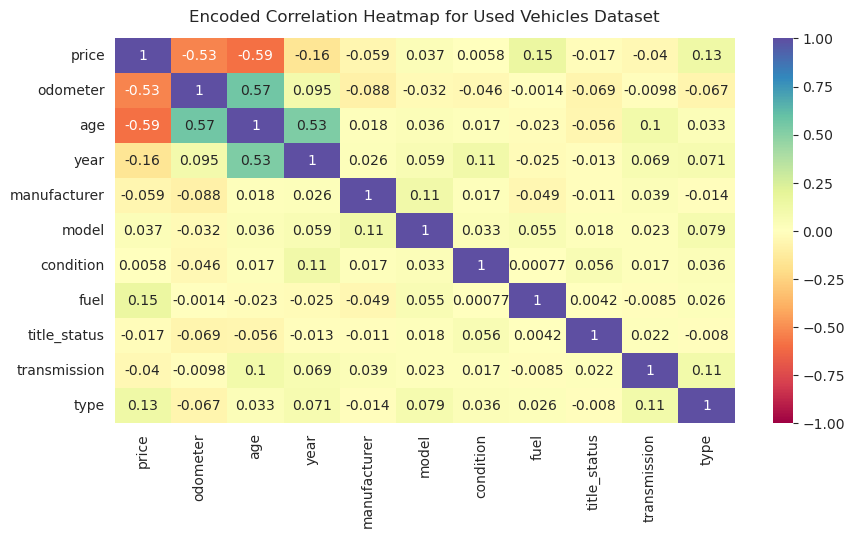

In [54]:
# Compute correlation matrix
corr_matrix = vehicles_used_enc.select([F.col(c).cast("double").alias(c) for c in vehicles_used_enc.columns]).toPandas().corr()

# Plot correlation matrix
f, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Encoded Correlation Heatmap for Used Vehicles Dataset', pad=12)
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='Spectral')

# convert the plot to an image file
#img_bytes = io.BytesIO()
#plt.savefig(img_bytes, format='png')
#img_bytes.seek(0)

# upload the image to GCS
#blob_name = 'Heatmap.png'
#bucket = client.bucket(bucket_name)
#blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
#blob.upload_from_file(img_bytes, content_type='image/png')

In [55]:
vehicles_used_enc.columns

['price',
 'odometer',
 'age',
 'year',
 'manufacturer',
 'model',
 'condition',
 'fuel',
 'title_status',
 'transmission',
 'type']

In [56]:
features = VectorAssembler(inputCols = [
 'odometer',
 'age',
 'year',
 'manufacturer',
 'model',
 'condition',
 'fuel',
 'title_status',
 'transmission',
 'type'],outputCol='features')

training_features = features.transform(vehicles_used_enc)
training_features = training_features.select('price','features')
print('\n--- ML dataset ---\n')
training_features.show(3)
#split ML dataset in train (.8) and test (.2)
train_data, test_data = training_features.randomSplit([0.8,0.2])
print('\n--- Train Data ---\n')
train_data.show(3)
print('\n--- Test Data ---\n')
test_data.show(3)
print('\n--- Data Used for the Prediction---\n')
# amostrar aleatoriamente 5% dos dados para teste
test_data_sample = test_data.sample(fraction=0.05, seed=123)

# exibir as primeiras linhas do DataFrame
test_data_sample.show(5)


--- ML dataset ---



+-----+--------------------+
|price|            features|
+-----+--------------------+
|14888|[163169.0,14.0,10...|
| 4650|[139000.0,19.0,17...|
|25590|[1113.0,1.0,18.0,...|
+-----+--------------------+
only showing top 3 rows


--- Train Data ---



+-----+--------------------+
|price|            features|
+-----+--------------------+
| 2000|(10,[0,1,2,3,4],[...|
| 2000|(10,[0,1,2,3,4],[...|
| 2000|(10,[0,1,2,3,4],[...|
+-----+--------------------+
only showing top 3 rows


--- Test Data ---



+-----+--------------------+
|price|            features|
+-----+--------------------+
| 2000|(10,[0,1,2,4],[53...|
| 2000|(10,[0,1,2,4,5],[...|
| 2000|(10,[0,1,2,4,5],[...|
+-----+--------------------+
only showing top 3 rows


--- Data Used for the Prediction---



+-----+--------------------+
|price|            features|
+-----+--------------------+
| 2000|[200000.0,21.0,20...|
| 2200|[164000.0,20.0,19...|
| 2250|[98500.0,13.0,7.0...|
| 2300|[200000.0,16.0,13...|
| 2400|[191195.0,16.0,13...|
+-----+--------------------+
only showing top 5 rows



To start with, define a function for regression metrics

- R² measures how much variability in dependent variable can be "explained by the model.
- While R² is a relative measure of how well the model fits dependent variables, \nMean Square Error is an absolute measure of the goodness for the fit.
- Mean Absolute Error(MAE) is similar to MSE, however, unlike MSE, MAE takes the sum of the ABSOLUTE value of error.

In [57]:
def reg_metrics(model, train_data, test_data, algo):
    """ Function takes in training and testing sets, prediction model, 
    and ouputs the below metrics:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    """
    # Get predicted values on test_data
    test_pred = model.transform(test_data)
       
    #1 & 2 Coefficient of Determination (R² & Adjusted R²)
    print("\n\t--- Coefficient of Determination (R² & Adjusted R²) ---")
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(test_pred)
    adj_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2adj")
    adj_r2 = evaluator.evaluate(test_pred)

    print(f"R²\t\t: {r2:.5f}")
    print(f"Adjusted R²\t: {adj_r2:.5f}")

    #3 & 4. MSE and RMSE
    print("\n\t--- Mean Squared Error (MSE & RMSE) ---")
    mse_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
    mse = mse_evaluator.evaluate(test_pred)
    rmse_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    rmse = rmse_evaluator.evaluate(test_pred)
    
    print(f"MSE\t: {mse:.4f}")
    print(f"RMSE\t: {rmse:.2f}")

    #5. MAE
    print("\n\t--- Mean Absolute Error (MAE) ---")
    mae_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
    mae = mae_evaluator.evaluate(test_pred)
    print(f"MAE\t: {mae:.2f}")
    
    # Return metrics as a dictionary
    metrics_dict = {
        'Algorithm': algo,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    #'Adjusted R²': adj_r2_formatted,
    return metrics_dict

model_metrics = []
model_metrics_performance = []

## Linear Regression

In [58]:
# Measure execution time
start_time = time.time()
print("\t------- Linear Regression -------")
lr = LinearRegression(
    featuresCol='features',
    labelCol='price',
    maxIter=100,  # increase maxIter
    regParam=0.1,  # try different values for regParam
    elasticNetParam=0.7  # try different values for elasticNetParam
)
lr_model = lr.fit(train_data)
metrics_dict_lr = reg_metrics(lr_model, train_data, test_data, 'Linear Regression')
model_metrics.append(metrics_dict_lr)
print("\n\t--- Predictions ---")
pred_results = lr_model.evaluate(test_data_sample)
pred_results.predictions.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Linear Regression',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Linear Regression -------


23/05/02 21:22:32 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/02 21:22:32 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.45327
Adjusted R²	: 0.46314

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 59273912.8274
RMSE	: 7698.96

	--- Mean Absolute Error (MAE) ---


MAE	: 5850.98

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...| 5104.796740920017|
| 2500|[93870.0,6.0,2.0,...|18576.925845820275|
| 2500|[116000.0,15.0,12...|11856.199667039407|
| 2500|[164554.0,17.0,14...|3420.2066335861964|
| 2595|(10,[0,1,2,9],[14...|5982.6538286112045|
+-----+--------------------+------------------+
only showing top 5 rows



## Lasso Regression

In [59]:
start_time = time.time()
print("\t------- Lasso Regression -------")
lasso = LinearRegression(featuresCol='features', labelCol='price', maxIter=100, regParam=0.1, elasticNetParam=1)
lasso_model = lasso.fit(train_data)
metrics_dict_lasso = reg_metrics(lasso_model, train_data, test_data, 'Lasso Regression')
model_metrics.append(metrics_dict_lasso)
print("\n\t--- Predictions ---")
pred_results = lasso_model.transform(test_data_sample)
pred_results.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Lasso Regression',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Lasso Regression -------



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.46293
Adjusted R²	: 0.46293

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 59297873.0136
RMSE	: 7700.51

	--- Mean Absolute Error (MAE) ---


MAE	: 5852.74

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...|  5117.94311197563|
| 2500|[93870.0,6.0,2.0,...|18477.840721880257|
| 2500|[116000.0,15.0,12...| 11926.96185416077|
| 2500|[164554.0,17.0,14...| 3305.463839865559|
| 2595|(10,[0,1,2,9],[14...| 6057.401111365747|
+-----+--------------------+------------------+
only showing top 5 rows



## Ridge Regression

In [60]:
start_time = time.time()
print("\t------- Ridge Regression -------")
ridge = LinearRegression(featuresCol = 'features', labelCol = 'price',maxIter=100, regParam=0.3, elasticNetParam=0.1)
ridge_model = ridge.fit(train_data)
metrics_dict_ridge = reg_metrics(ridge_model, train_data, test_data, 'Ridge Regression')
model_metrics.append(metrics_dict_ridge)
print("\n\t--- Predictions ---")
pred_results = ridge_model.evaluate(test_data_sample)
pred_results.predictions.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Ridge Regression',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Ridge Regression -------



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.46293
Adjusted R²	: 0.46293

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 59297921.5520
RMSE	: 7700.51

	--- Mean Absolute Error (MAE) ---


MAE	: 5852.74

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...|  5118.01339037071|
| 2500|[93870.0,6.0,2.0,...| 18477.89756066542|
| 2500|[116000.0,15.0,12...|11927.192422379267|
| 2500|[164554.0,17.0,14...|  3304.98473717496|
| 2595|(10,[0,1,2,9],[14...| 6057.644432296172|
+-----+--------------------+------------------+
only showing top 5 rows



## Isotonic Regression

In [61]:
start_time = time.time()
print("\t------- Isotonic Regression -------")
iso = IsotonicRegression(labelCol="price", featuresCol="features")
iso_model = iso.fit(train_data)
metrics_dict_iso = reg_metrics(iso_model, train_data, test_data, 'Isotonic Regression')
model_metrics.append(metrics_dict_iso)
print("\n\t--- Predictions ---")
pred_results = iso_model.transform(test_data_sample)
pred_results.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Isotonic Regression',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Isotonic Regression -------



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.00064
Adjusted R²	: 0.00064

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 110339208.6658
RMSE	: 10504.25

	--- Mean Absolute Error (MAE) ---


MAE	: 8341.16

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...|15056.566845104871|
| 2500|[93870.0,6.0,2.0,...|15056.566845104871|
| 2500|[116000.0,15.0,12...|15056.566845104871|
| 2500|[164554.0,17.0,14...|15056.566845104871|
| 2595|(10,[0,1,2,9],[14...|15056.566845104871|
+-----+--------------------+------------------+
only showing top 5 rows



## Factorization Machines Regression

In [63]:
start_time = time.time()
print("\t------- Factorization Machines Regression -------")
# Define the FMRegressor model
fm = FMRegressor(featuresCol="features", labelCol="price", stepSize=0.01)
# Train the model on the training data
fm_model = fm.fit(train_data)

# Evaluate the model on the training and test data
metrics_dict_fm = reg_metrics(fm_model, train_data, test_data, 'Factorization Machines Regression')
model_metrics.append(metrics_dict_fm)
print("\n\t--- Predictions ---")
# Make predictions on the test data
pred_results = fm_model.transform(test_data_sample)
pred_results.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Factorization Machines',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
}
model_metrics_performance.append(metrics_dict_time)

	------- Factorization Machines Regression -------



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: -0.83389
Adjusted R²	: -0.83389

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 203808773.7204
RMSE	: 14276.16

	--- Mean Absolute Error (MAE) ---


MAE	: 10499.59

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...| 14073.41549672946|
| 2500|[93870.0,6.0,2.0,...|16082.239598370237|
| 2500|[116000.0,15.0,12...|10799.947200751143|
| 2500|[164554.0,17.0,14...|13906.258433499039|
| 2595|(10,[0,1,2,9],[14...| 10318.82706947265|
+-----+--------------------+------------------+
only showing top 5 rows



## Decision Tree

In [64]:
start_time = time.time()
print("\t------- Decision Tree -------")
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'price', maxDepth=5, maxBins=10000)
dt_model = dt.fit(train_data)
metrics_dict_dt = reg_metrics(dt_model, train_data, test_data, 'Decision Tree')
model_metrics.append(metrics_dict_dt)
print("\n\t--- Predictions ---")
pred_results = dt_model.transform(test_data_sample)
pred_results.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Decision Tree',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Decision Tree -------



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.43750
Adjusted R²	: 0.43750

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 62104987.8191
RMSE	: 7880.67

	--- Mean Absolute Error (MAE) ---


MAE	: 4340.58

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...| 5031.722311733801|
| 2500|[93870.0,6.0,2.0,...| 46748.23411371237|
| 2500|[116000.0,15.0,12...| 5031.722311733801|
| 2500|[164554.0,17.0,14...| 5031.722311733801|
| 2595|(10,[0,1,2,9],[14...|10656.522290545734|
+-----+--------------------+------------------+
only showing top 5 rows



## Random Forest Regression

In [65]:
start_time = time.time()
print("\t------- Random Forest Regression -------")
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'price', numTrees=2, maxDepth=2, maxBins=10000)
rf_model = rf.fit(train_data)
metrics_dict_rf = reg_metrics(rf_model, train_data, test_data, 'Random Forest Regression')
model_metrics.append(metrics_dict_rf)
print("\n\t--- Predictions ---")
pred_results = rf_model.transform(test_data_sample)
pred_results.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Random Forest',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Random Forest Regression -------



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.58650
Adjusted R²	: 0.58650

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 45654810.5033
RMSE	: 6756.83

	--- Mean Absolute Error (MAE) ---


MAE	: 5173.77

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...|11817.797575084507|
| 2500|[93870.0,6.0,2.0,...|21661.171376743372|
| 2500|[116000.0,15.0,12...|11817.797575084507|
| 2500|[164554.0,17.0,14...| 9276.970803680297|
| 2595|(10,[0,1,2,9],[14...|16981.681766722308|
+-----+--------------------+------------------+
only showing top 5 rows



## Gradient Boosting Regression

In [66]:
start_time = time.time()
print("\t------- Gradient Boosting Regression -------")
gb = GBTRegressor(featuresCol = 'features', labelCol = 'price', maxIter=10, maxDepth=5, seed=42, maxBins=10000)
gb_model = gb.fit(train_data)
metrics_dict_gb = reg_metrics(gb_model, train_data, test_data, 'Gradient Boost Regression')
model_metrics.append(metrics_dict_gb)
print("\n\t--- Predictions ---")
pred_results = gb_model.transform(test_data_sample)
pred_results.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Gradient Boosting',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Gradient Boosting Regression -------


23/05/02 21:29:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1067.5 KiB
23/05/02 21:29:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
23/05/02 21:29:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1184.4 KiB
23/05/02 21:29:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1246.9 KiB
23/05/02 21:29:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1362.0 KiB
23/05/02 21:29:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1460.0 KiB
23/05/02 21:29:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1461.0 KiB
23/05/02 21:29:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1578.5 KiB
23/05/02 21:29:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas


	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.27170
Adjusted R²	: 0.27170

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 80411349.2997
RMSE	: 8967.24

	--- Mean Absolute Error (MAE) ---


MAE	: 4093.72

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...|3733.2881980242646|
| 2500|[93870.0,6.0,2.0,...|53287.975170942795|
| 2500|[116000.0,15.0,12...| 4728.330781562629|
| 2500|[164554.0,17.0,14...|3316.9531207979367|
| 2595|(10,[0,1,2,9],[14...| 6316.016750425248|
+-----+--------------------+------------------+
only showing top 5 rows



## Generalized Linear Regression

In [67]:
start_time = time.time()
print("\t------- Generalized Linear Regression -------")
glr = GeneralizedLinearRegression(featuresCol = 'features', labelCol = 'price',family="gaussian", link="identity", maxIter=10, regParam=0.3)
glr_model = glr.fit(train_data)
metrics_dict_glr = reg_metrics(glr_model, train_data, test_data, 'Generalized Linear Regression')
model_metrics.append(metrics_dict_glr)
print("\n\t--- Predictions ---")
pred_results = glr_model.transform(test_data_sample)
pred_results.show(5)

end_time = time.time()
elapsed_time = end_time - start_time
# Measure CPU usage
cpu_usage = psutil.cpu_percent()

metrics_dict_time = {
        'Algorithm':'Generalized Linear Regression',
        'Execution Time': elapsed_time,
        'CPU usage': cpu_usage
    }
model_metrics_performance.append(metrics_dict_time)

	------- Generalized Linear Regression -------


23/05/02 21:31:27 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/05/02 21:31:27 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK



	--- Coefficient of Determination (R² & Adjusted R²) ---


R²		: 0.46293
Adjusted R²	: 0.46293

	--- Mean Squared Error (MSE & RMSE) ---


MSE	: 59297931.4174
RMSE	: 7700.52

	--- Mean Absolute Error (MAE) ---


MAE	: 5852.74

	--- Predictions ---


+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
| 2495|(10,[0,1,2,3,4],[...| 5118.030985992133|
| 2500|[93870.0,6.0,2.0,...|18477.929571527464|
| 2500|[116000.0,15.0,12...|11927.259413834752|
| 2500|[164554.0,17.0,14...|3304.7406999688974|
| 2595|(10,[0,1,2,9],[14...| 6057.711513342183|
+-----+--------------------+------------------+
only showing top 5 rows



## Models comparison

In [68]:
# Create a Spark DataFrame from the list of dictionaries
df_models1 = spark.createDataFrame(model_metrics)

# Select columns in desired order and round the values to two decimal places
df_models = df_models1.withColumn("MSE", col("MSE").cast("decimal(20,2)")).select("Algorithm", 
                              round("R²", 2).alias("R²"), 
                              round("Adjusted R²", 2).alias("Adjusted R²"), 
                              "MSE", 
                              round("RMSE", 2).alias("RMSE"), 
                              round("MAE", 2).alias("MAE"))

# Set the option to display the full column width
df_models.show()

+--------------------+-----+-----------+------------+--------+--------+
|           Algorithm|   R²|Adjusted R²|         MSE|    RMSE|     MAE|
+--------------------+-----+-----------+------------+--------+--------+
|   Linear Regression| 0.45|       0.46| 59273912.83| 7698.96| 5850.98|
|    Lasso Regression| 0.46|       0.46| 59297873.01| 7700.51| 5852.74|
|    Ridge Regression| 0.46|       0.46| 59297921.55| 7700.51| 5852.74|
| Isotonic Regression|  0.0|        0.0|110339208.67|10504.25| 8341.16|
|Factorization Mac...|-0.83|      -0.83|203808773.72|14276.16|10499.59|
|       Decision Tree| 0.44|       0.44| 62104987.82| 7880.67| 4340.58|
|Random Forest Reg...| 0.59|       0.59| 45654810.50| 6756.83| 5173.77|
|Gradient Boost Re...| 0.27|       0.27| 80411349.30| 8967.24| 4093.72|
|Generalized Linea...| 0.46|       0.46| 59297931.42| 7700.52| 5852.74|
+--------------------+-----+-----------+------------+--------+--------+



In [69]:
# Define the schema of the DataFrame
schema = StructType([
    StructField("Algorithm", StringType(), True),
    StructField("Execution Time", DoubleType(), True),
    StructField("CPU usage", DoubleType(), True)
])

# Create the DataFrame using the schema
df_models_performance = spark.createDataFrame(model_metrics_performance, schema=schema)
df_models_performance.show()

+--------------------+------------------+---------+
|           Algorithm|    Execution Time|CPU usage|
+--------------------+------------------+---------+
|   Linear Regression|49.853346824645996|      5.0|
|    Lasso Regression|21.311098098754883|      8.5|
|    Ridge Regression| 24.60332489013672|     11.9|
| Isotonic Regression|21.832613229751587|     12.2|
|Factorization Mac...| 78.16695833206177|      6.9|
|       Decision Tree|45.964171409606934|      6.6|
|       Random Forest|19.610944509506226|     12.0|
|   Gradient Boosting|101.78742051124573|      9.6|
|Generalized Linea...|19.850269317626953|      7.7|
+--------------------+------------------+---------+



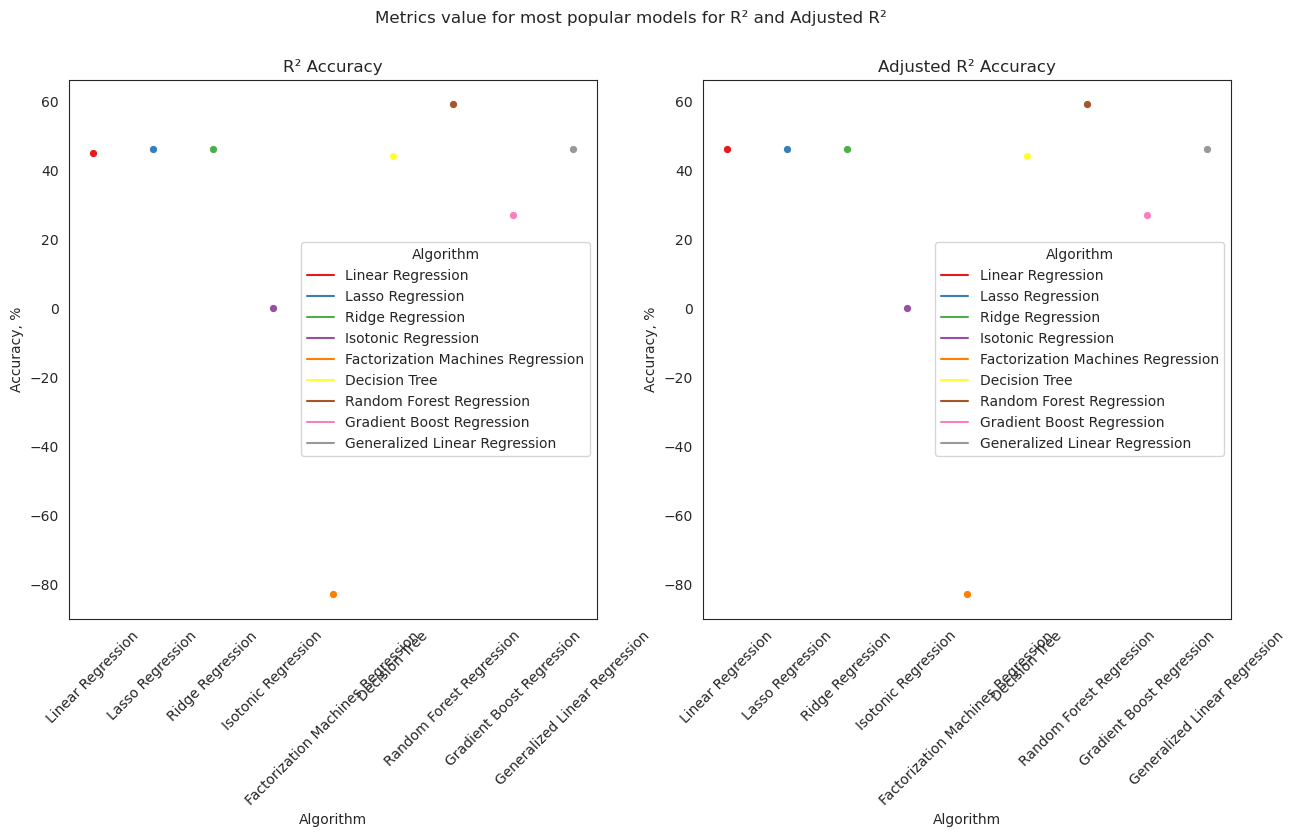

In [70]:
# Rearrange the data frame
metric_df_plot1 = df_models.select('Algorithm', (df_models['R²']*100).alias('R²'), (df_models['Adjusted R²']*100).alias('Adjusted R²')) \
                            .toPandas() \
                            .rename(columns={'R²': 'R2', 'Adjusted R²': 'Adjusted_R2'})

metric_plot_df_1 = metric_df_plot1.melt(id_vars=['Algorithm'], var_name='Metric', value_name='Accuracy')

# Create separate dataframes for R2 and Adjusted R2
metric_plot_df_r2 = metric_plot_df_1[metric_plot_df_1['Metric'] == 'R2']
metric_plot_df_adj_r2 = metric_plot_df_1[metric_plot_df_1['Metric'] == 'Adjusted_R2']

# Plot the line chart
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].set_title('R² Accuracy')
axes[1].set_title('Adjusted R² Accuracy')
sns.lineplot(ax=axes[0], data=metric_plot_df_r2, x='Algorithm', y='Accuracy', marker='o', hue='Algorithm', ci=None, palette='Set1')
sns.lineplot(ax=axes[1], data=metric_plot_df_adj_r2, x='Algorithm', y='Accuracy', marker='o', hue='Algorithm', ci=None, palette='Set1')
for ax in axes:
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Accuracy, %')
    ax.tick_params(axis='x', rotation=45)
plt.suptitle('Metrics value for most popular models for R² and Adjusted R²')

# convert the plot to an image file
img_bytes = io.BytesIO()
plt.savefig(img_bytes, format='png')
img_bytes.seek(0)

# upload the image to GCS
blob_name = 'Metrics_R²_and_Adjusted_R².png'
bucket = client.bucket(bucket_name)
blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
blob.upload_from_file(img_bytes, content_type='image/png')

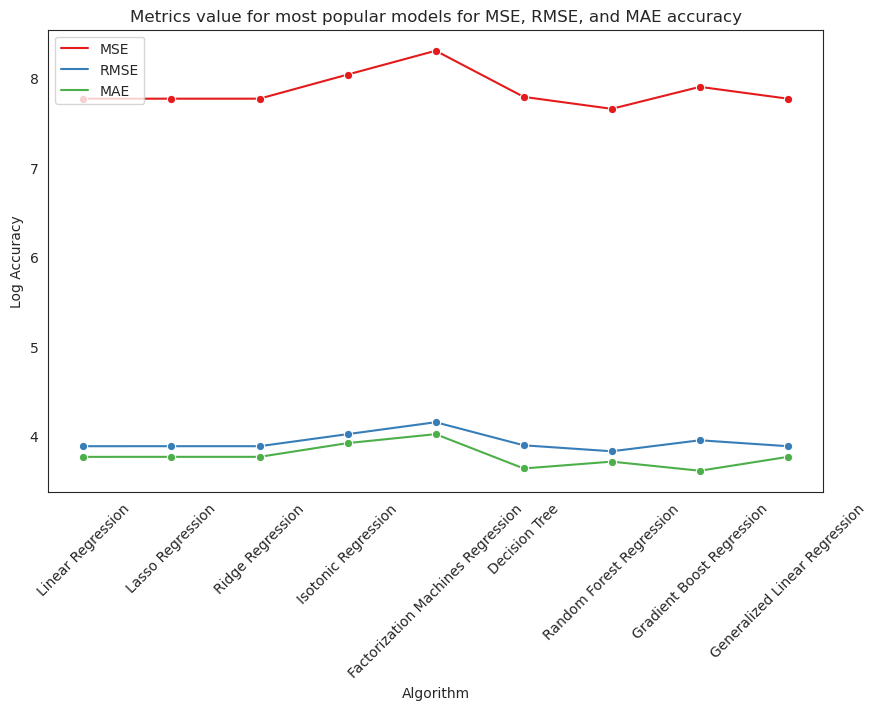

In [71]:
# Rearrange the data frame
metric_df_plot1 = df_models.select('Algorithm', 'MSE', 'RMSE', 'MAE') \
                            .toPandas()

metric_plot_df_1 = metric_df_plot1.melt(id_vars=['Algorithm'], var_name='Metric', value_name='Accuracy')

# Convert values to log scale
metric_plot_df_1['Accuracy'] = pd.to_numeric(metric_plot_df_1['Accuracy'], errors='coerce')
metric_plot_df_1['Accuracy'] = np.log10(metric_plot_df_1['Accuracy'])

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=metric_plot_df_1, x='Algorithm', y='Accuracy', marker='o', hue='Metric', ci=None, palette='Set1')

ax.set_xlabel('Algorithm')
ax.set_ylabel('Log Accuracy')
ax.set_title('Metrics value for most popular models for MSE, RMSE, and MAE accuracy')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left')

# convert the plot to an image file
img_bytes = io.BytesIO()
plt.savefig(img_bytes, format='png')
img_bytes.seek(0)

# upload the image to GCS
blob_name = 'Metrics_MSE_RMSE_MAE.png'
bucket = client.bucket(bucket_name)
blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
blob.upload_from_file(img_bytes, content_type='image/png')

/tmp/ipykernel_4073/4114868167.py:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



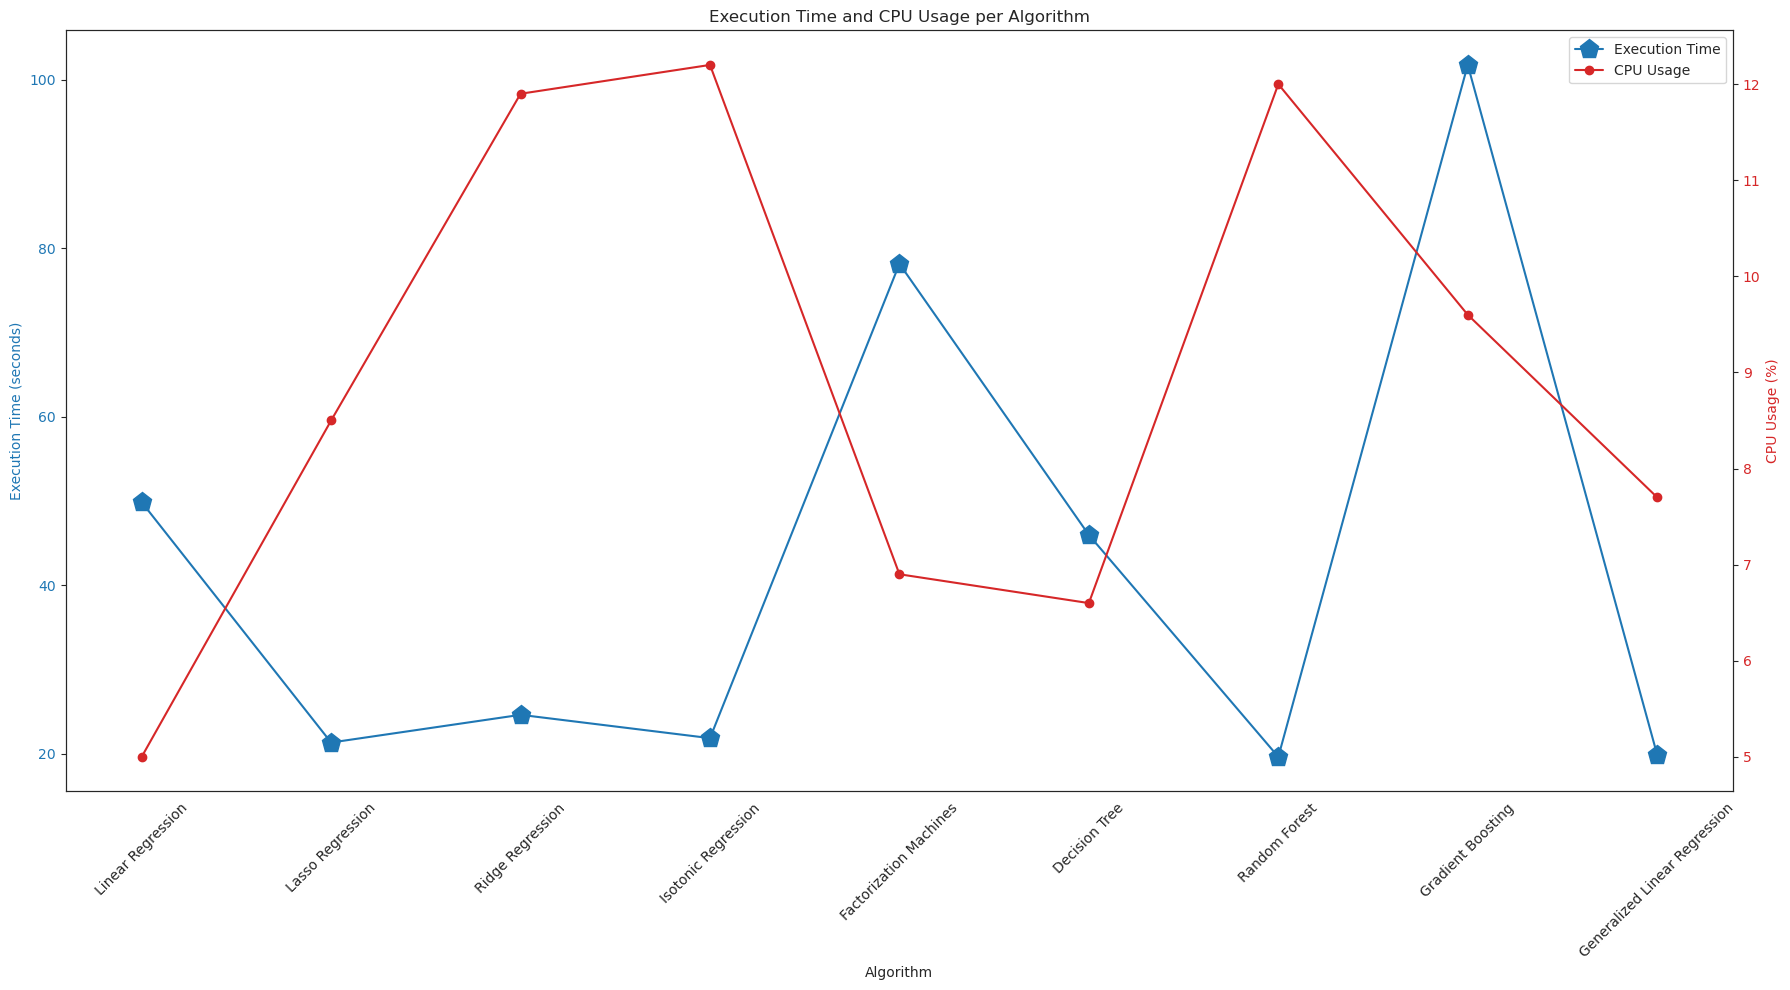

In [79]:
# Get the Algorithm, Execution Time, and CPU usage columns from the DataFrame
x = df_models_performance.select("Algorithm").rdd.flatMap(lambda x: x).collect()
y1 = df_models_performance.select("Execution Time").rdd.flatMap(lambda x: x).collect()
y2 = df_models_performance.select("CPU usage").rdd.flatMap(lambda x: x).collect()

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(18, 10))

# Plot Execution Time on the left axis as a line plot
line1 = ax1.plot(x, y1, color='tab:blue', marker='p', markersize=14, label='Execution Time')
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Execution Time (seconds)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticklabels(x, rotation=45)
# Create a twin axis to plot CPU usage on the right axis
ax2 = ax1.twinx()

# Plot CPU usage on the right axis as a scatter plot
line2 = ax2.plot(x, y2, color='tab:red', marker='o', label='CPU Usage')
ax2.set_ylabel('CPU Usage (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Concatenate the lines from both axes into a single list
lines = line1 + line2

# Create a legend for both axes
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

# Set the title
plt.title('Execution Time and CPU Usage per Algorithm')
plt.tight_layout()
# convert the plot to an image file
img_bytes = io.BytesIO()
plt.savefig(img_bytes, format='png')
img_bytes.seek(0)

# upload the image to GCS
blob_name = 'Metrics_Execution_Time_and_CPU_Usage.png'
bucket = client.bucket(bucket_name)
blob = bucket.blob('{}/{}'.format(folder_name, blob_name))
blob.upload_from_file(img_bytes, content_type='image/png')

# Recomendation System

Example of what we want to do: 

recommend("American","light color","luxury_small",(5000,10000)) 

Output: Table with cars with similar features

In [44]:
selected_colors = ['white', 'silver', 'yellow', 'orange', 'green', 'custom', 'black', 'red', 'blue', 'purple', 'grey', 'brown']
selected_types = ['sedan', 'convertible', 'coupe', 'hatchback', 'other', 'SUV', 'wagon', 'pickup', 'offroad', 'truck', 'van', 'mini-van', 'bus']

rec_df = df.filter((col('paint_color').isin(selected_colors)) & (col('type').isin(selected_types))).select(*df.columns)

rec_df.show()

+----------+--------------------+----------+--------------------+-----+----+------------+--------------------+---------+-----------+------+--------+------------+------------+-----------------+-----+----+------+-----------+--------------------+--------------------+------+-----+---------+----------+--------------------+-------------------+
|        id|                 url|    region|          region_url|price|year|manufacturer|               model|condition|  cylinders|  fuel|odometer|title_status|transmission|              VIN|drive|size|  type|paint_color|           image_url|         description|county|state|      lat|      long|        posting_date|           category|
+----------+--------------------+----------+--------------------+-----+----+------------+--------------------+---------+-----------+------+--------+------------+------------+-----------------+-----+----+------+-----------+--------------------+--------------------+------+-----+---------+----------+--------------------+-

## Create manufacturer countries, this means, the 'Made' column

In [45]:
def country(manufacturer):
    american = ['harley-davidson', 'chevrolet', 'pontiac', 'ram', 'ford', 'gmc', 'tesla', 'jeep', 'dodge',
                'cadillac', 'chrysler', 'lincoln', 'buick', 'saturn', 'mercury']
    japanese = ['lexus', 'nissan', 'toyota', 'acura', 'honda', 'infiniti', 'subaru', 'mitsubishi', 'datsun', 'mazda']
    german = ['volkswagen', 'mercedes-benz', 'bmw', 'audi', 'porsche']
    italian = ['ferrari', 'fiat', 'alfa-romeo']
    korean = ['kia', 'hyundai']
    swedish = ['volvo']
    english = ['rover', 'mini', 'land rover', 'jaguar']
    
    return when(col('manufacturer').isin(american), 'American') \
        .when(col('manufacturer').isin(japanese), 'Japanese') \
        .when(col('manufacturer').isin(german), 'German') \
        .when(col('manufacturer').isin(italian), 'Italian') \
        .when(col('manufacturer').isin(korean), 'Korean') \
        .when(col('manufacturer').isin(swedish), 'Swedish') \
        .when(col('manufacturer').isin(english), 'English') \
        .otherwise(None)

rec_df = rec_df.withColumn('Made', country(col('manufacturer')))

rec_df.select('Made', 'manufacturer').show()

+----+------------+
|Made|manufacturer|
+----+------------+
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
|null|        null|
+----+------------+
only showing top 20 rows



## Create cars age, this means, the 'age' column

In [46]:
# Add a new column for age of cars
rec_df = rec_df.withColumn('age', year('posting_date') - rec_df['year'])

## Create cars mil rating, this means, the 'mil_rating' column

In [47]:
rec_df = rec_df.withColumn("avg_mil", col("odometer") / col("Age"))
rec_df = rec_df.withColumn("mil_rating", when(rec_df['avg_mil'] > 21500, "above average").otherwise("below average"))

## Create cars luxury division, this means, the 'type_group' column

In [48]:
# Define UDF for the luxury function
luxury_udf = udf(lambda type_: "luxury_small" if type_ in ['sedan', 'convertible','coupe','hatchback','other']
                 else "luxury_large" if type_ in ['SUV','wagon']
                 else "non-luxury_small" if type_ in ['pickup','truck','offroad']
                 else "non-luxury_large" if type_ in ['van','mini-van','bus']
                 else None, StringType())

# Apply UDF to create new column in DataFrame
rec_df = rec_df.withColumn('type_group', luxury_udf('type'))

rec_df.select('type_group', 'type').show()

+----------------+------+
|      type_group|  type|
+----------------+------+
|    luxury_large|   SUV|
|    luxury_small| sedan|
|    luxury_small| sedan|
|    luxury_large|   SUV|
|    luxury_small| sedan|
|    luxury_small| sedan|
|    luxury_large|   SUV|
|    luxury_small| coupe|
|    luxury_small| sedan|
|    luxury_large|   SUV|
|    luxury_small| sedan|
|non-luxury_small|pickup|
|non-luxury_small|pickup|
|non-luxury_small|pickup|
|non-luxury_small|pickup|
|non-luxury_small|pickup|
|non-luxury_small|pickup|
|    luxury_large|   SUV|
|    luxury_small| sedan|
|    luxury_small| sedan|
+----------------+------+
only showing top 20 rows



## Create cars colours division, this means, the 'color_group' column

In [49]:
# create column 'color_group' based on 'paint_color'
rec_df = rec_df.withColumn('color_group', when(col('paint_color').isin(['white','silver','yellow','orange','green','custom']), 'light color').otherwise('dark color'))

rec_df.select('paint_color', 'color_group').show()

+-----------+-----------+
|paint_color|color_group|
+-----------+-----------+
|      white|light color|
|      white|light color|
|      black| dark color|
|      white|light color|
|      white|light color|
|      white|light color|
|      white|light color|
|      white|light color|
|        red| dark color|
|     silver|light color|
|      white|light color|
|      white|light color|
|      white|light color|
|      black| dark color|
|      white|light color|
|      black| dark color|
|       grey| dark color|
|      white|light color|
|      white|light color|
|      white|light color|
+-----------+-----------+
only showing top 20 rows



## Prepare dataset to be used in the recognition system

In [50]:
cols_to_drop = ['id','url', 'region', 'region_url', 'VIN', 'image_url', 'description', \
    'county', 'size', 'drive', 'cylinders', 'state', 'lat','long']
rec_df = rec_df.drop(*cols_to_drop)

# Remove null values and duplicated rows
rec_df = rec_df.drop_duplicates()

# Initial cleaning up
# Drop NaNs and duplicates
rec_df = rec_df.na.drop()

rec_df.printSchema()

root
 |-- price: long (nullable = true)
 |-- year: double (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- posting_date: string (nullable = true)
 |-- category: string (nullable = true)
 |-- Made: string (nullable = true)
 |-- age: double (nullable = true)
 |-- avg_mil: double (nullable = true)
 |-- mil_rating: string (nullable = false)
 |-- type_group: string (nullable = true)
 |-- color_group: string (nullable = false)



In [51]:
# Function for recommending cars based on car manufacturer country. 
# It takes car manufacturer country, color group, type group  and price range as input.

def recommend(made, color_group, type_group, price_range):
    # Matching the type with the dataset
    data = rec_df.filter((rec_df.color_group == color_group) & 
                         (rec_df.type_group == type_group) &
                         (rec_df.price >= price_range[0]) &
                         (rec_df.price <= price_range[1]) &
                         (rec_df.Made == made))
    
    # Convert the car manufacturer country into vectors and used unigram
    tokenizer = RegexTokenizer(inputCol="Made", outputCol="words", pattern="\\W")
    stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    cv = CountVectorizer(inputCol="filtered", outputCol="raw_features", vocabSize=2**16, minDF=1.0)
    idf = IDF(inputCol="raw_features", outputCol="features", minDocFreq=5)
    
    pipeline = Pipeline(stages=[tokenizer, stop_words_remover, cv, idf])
    pipeline_model = pipeline.fit(data)
    tfidf_matrix = pipeline_model.transform(data)
    
    # Calculating the similarity measures based on Cosine Similarity
    assembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")
    assembled_data = assembler.transform(tfidf_matrix)
    normalizer = Normalizer(inputCol="features_vec", outputCol="features_norm", p=2.0)
    normalized_data = normalizer.transform(assembled_data)
    
    # Selecionando o top 5 de carros semelhantes
    idx = normalized_data.select('features_norm').collect()[0]
    sig = normalized_data.rdd.map(lambda row: (row.price, row.features_norm.dot(idx[0]))) \
                             .sortBy(lambda x: -x[1]) \
                             .take(6)[1:]

    # car indices
    car_indices = [i[0] for i in sig]
    
    # Top 5 car recommendations
    rec = data.select('price', 'Made', 'manufacturer', 'model', 'type', 'year', 'Age', 'condition', 'fuel',
                      'title_status', 'transmission', 'paint_color', 'mil_rating') \
              .filter(F.col('price').isin(car_indices)) \
              .orderBy('price') \
              .drop('id')
    rec_splits = rec.randomSplit([0.1, 0.1], seed=42)
    rec_sample = rec_splits[0].limit(5)
    return rec_sample.show()

In [52]:
print('\nRecommendation 1\n')
recommend("Japanese", "light color", "luxury_small", (5000, 6000))

print('\nRecommendation 2\n')
recommend("American", "dark color", "luxury_large", (1000, 20000))

print('\nRecommendation 3\n')
recommend("German", "light color", "luxury_small", (1000, 6000))

print('\nRecommendation 4\n')
recommend("Italian", "light color", "luxury_small", (1000, 5000000))

print('\nRecommendation 5\n')
recommend("Korean", "light color", "luxury_small", (3000, 20000))


Recommendation 1



+-----+--------+------------+------+---------+------+----+---------+----+------------+------------+-----------+-------------+
|price|    Made|manufacturer| model|     type|  year| Age|condition|fuel|title_status|transmission|paint_color|   mil_rating|
+-----+--------+------------+------+---------+------+----+---------+----+------------+------------+-----------+-------------+
| 5000|Japanese|       honda|accord|    sedan|2006.0|15.0|excellent| gas|       clean|   automatic|     custom|below average|
| 5000|Japanese|       honda|accord|    sedan|2008.0|13.0|     fair| gas|       clean|   automatic|     silver|below average|
| 5000|Japanese|       lexus| ls430|    sedan|2001.0|20.0|     good| gas|       clean|   automatic|     silver|below average|
| 5000|Japanese|       mazda|     2|hatchback|2013.0| 8.0|     good| gas|     salvage|   automatic|      green|below average|
| 5000|Japanese|      toyota| camry|    sedan|2007.0|14.0|     good| gas|       clean|   automatic|     custom|below a

+-----+--------+------------+---------------+----+------+----+---------+----+------------+------------+-----------+-------------+
|price|    Made|manufacturer|          model|type|  year| Age|condition|fuel|title_status|transmission|paint_color|   mil_rating|
+-----+--------+------------+---------------+----+------+----+---------+----+------------+------------+-----------+-------------+
| 2000|American|   chevrolet|          tahoe| SUV|2001.0|20.0|     fair| gas|       clean|   automatic|      brown|below average|
| 2000|American|       dodge|    durango 4x4| SUV|2002.0|19.0|     fair| gas|       clean|   automatic|       grey|below average|
| 2000|American|        ford|          f-150| SUV|1993.0|28.0|     fair| gas|       clean|      manual|      black|below average|
| 2000|American|         gmc|          yukon| SUV|2002.0|19.0|     good| gas|       clean|   automatic|       blue|below average|
| 4950|American|   chevrolet|suburban le 4x4| SUV|2002.0|19.0|excellent| gas|       clean|

+-----+------+-------------+---------+-----+------+----+---------+------+------------+------------+-----------+-------------+
|price|  Made| manufacturer|    model| type|  year| Age|condition|  fuel|title_status|transmission|paint_color|   mil_rating|
+-----+------+-------------+---------+-----+------+----+---------+------+------------+------------+-----------+-------------+
| 2999|German|mercedes-benz|     benz|sedan|1995.0|26.0|     good|diesel|       clean|   automatic|      green|below average|
| 3850|German|mercedes-benz|benz e350|sedan|2002.0|19.0| like new|   gas|       clean|   automatic|     silver|below average|
| 4500|German|          bmw|   325 xi|sedan|2004.0|17.0|excellent|   gas|       clean|   automatic|      green|below average|
| 4500|German|          bmw|     325i|coupe|2004.0|17.0|     good|   gas|       clean|   automatic|      white|below average|
| 4500|German|mercedes-benz|     e300|sedan|1993.0|28.0|excellent|   gas|       clean|   automatic|     yellow|below a

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 48032)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
 

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42531)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4550/296438846.py", line 11, in <module>
    recommend("Italian", "light color", "luxury_small", (1000, 5000000))
  File "/tmp/ipykernel_4550/444193842.py", line 19, in recommend
    pipeline_model = pipeline.fit(data)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/pipeline.py", line 114, in _fit
    model = stage.fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/base.py", line 161, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 335, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/pyspark

Py4JError: An error occurred while calling o2460.fit